In [1]:
## ensemble methods

## sleep stage classification - 2 class - using SAX features
## feature set variables: window size (0.5, 0.2, 0.1, 0.05), alphabet size (3, 4, 5), word size (dimer, trimer)

## do 10-fold CV
## inside cross-validation, split into train, validation & test indices
## do calc on train & val to get optimal params
#     try :
#     balance with smote / balanced class weight in SVM
#     grid search + CV  -> show plots on train & val error
#     optimise prob thres

## with the optimal params, re-train using train & val, then predict on test set
## merge test set predictions from all folds into a single set - obtain sensitivity, specificity & conf mat on this set

import pandas as pd
import numpy as np
import os
import pickle
from scipy import stats
#import itertools
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.preprocessing import StandardScaler #, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split

import itertools
from sklearn.svm import SVC
from sklearn.metrics import auc,accuracy_score
from sklearn.metrics import precision_recall_fscore_support,confusion_matrix
from sklearn.metrics import classification_report

In [2]:
###################function to plot confusion matrix#####################################
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
###########################################################################################

In [3]:
## create train & test sets by ID
def CreateTrainTestID(dfull):
    
    ## select IDs
    ID = dfull['pID'].unique() # create ID list
    #np.random.seed(456)   ## select the IDs for the 2 sets
    
    '''
    msk = np.random.rand(len(ID)) < 0.8
    #print('msk')
    #print(msk)
    trainIDs = pd.DataFrame()
    testIDs = pd.DataFrame()
    trainIDs['pID'] = ID[msk]
    testIDs['pID'] = ID[~msk]
    #print(ID[msk])
    #print(ID[~msk])
    print(trainIDs['pID'].tolist())
    print(testIDs['pID'].tolist())
    Train = dfull.loc[dfull['pID'].isin(ID[msk])] # create the train-test sets
    Test = dfull.loc[dfull['pID'].isin(ID[~msk])] #'''
    
    index_list = list(range(len(ID)))
    #print('index list')
    #print(index_list)
    train_index = np.random.choice(np.array(index_list), size = round(0.8*(len(index_list))), replace=False)
    test_index = [i for i in index_list if i not in train_index]
    Train = dfull.loc[dfull['pID'].isin(ID[train_index])]
    Test = dfull.loc[dfull['pID'].isin(ID[test_index])]
    #print('train')
    print(train_index)
    #print('test')
    print(test_index)
        
    return Train, Test

def createXYsets(Train,Test):    
    ## create the sets
    X_train1 = Train.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)  ## create X & y splits
    X_train1 = X_train1.drop(['index'], 1)
    X_test = Test.drop(['pID','day','epoch','class_label','class2'], 1).reset_index() #inplace=True, drop=True)
    X_test = X_test.drop(['index'],1)
    y_train1 = Train['class2'].reset_index() #inplace=True, drop=True)
    y_train1 = y_train1.drop(['index'],1)
    y_test = Test['class2'].reset_index() #inplace=True, drop=True)
    y_test = y_test.drop(['index'],1)
    print(X_train1.head(1))
    return X_train1, y_train1, X_test, y_test

In [4]:
### load data ###

file_location='C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data' #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018'
os.chdir('C:/Users/DAR9KOR/Desktop/data/HEALTHCARE/EEG/data/eeg_epochs_dec12_2018/raw_data') #'/home/intern_eyecare/Desktop/EEG/raw_data') #C:\\Users\\DAR9KOR\\Desktop\\data\\HEALTHCARE\\EEG\\data\\eeg_epochs_dec12_2018')

# remove 2nd night of subject 13, as there was data loss - pkl file created accordingly
dfull = pickle.load(open('Frac_sax_dimer_0.1s_rm_1st_wake.pkl', 'rb'))
dfull.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,pID,day,epoch,class_label
0,0.093960,0.043624,0.026846,0.003356,0.046980,0.117450,0.107383,0.026846,0.026846,0.104027,0.134228,0.070470,0.003356,0.033557,0.067114,0.093960,400,1,s2e1,wake
1,0.080537,0.023490,0.000000,0.000000,0.020134,0.288591,0.097315,0.003356,0.003356,0.093960,0.218121,0.030201,0.000000,0.000000,0.033557,0.107383,400,1,s3e1,wake
2,0.120805,0.023490,0.000000,0.000000,0.020134,0.244966,0.083893,0.000000,0.003356,0.077181,0.278523,0.016779,0.000000,0.000000,0.016779,0.114094,400,1,s4e1,wake
3,0.163880,0.053512,0.023411,0.003344,0.066890,0.163880,0.033445,0.016722,0.013378,0.053512,0.096990,0.066890,0.000000,0.010033,0.076923,0.157191,400,1,s5e1,wake
4,0.120401,0.036789,0.033445,0.020067,0.053512,0.140468,0.036789,0.013378,0.036789,0.063545,0.197324,0.040134,0.000000,0.006689,0.066890,0.133779,400,1,s5e2,wake


In [5]:
# 2. check data distribution
dfull.groupby('class_label').size()

class_label
sleep_stage_1     2804
sleep_stage_2    17799
wake             37566
dtype: int64

In [6]:
dfull.groupby(['pID','class_label']).size()

pID  class_label  
400  sleep_stage_1     117
     sleep_stage_2     623
     wake             1992
401  sleep_stage_1     201
     sleep_stage_2    1222
     wake             2319
402  sleep_stage_1     278
     sleep_stage_2     947
     wake             2292
403  sleep_stage_1     106
     sleep_stage_2     885
     wake             2173
404  sleep_stage_1     303
     sleep_stage_2    1134
     wake             1421
405  sleep_stage_1     158
     sleep_stage_2     833
     wake             1668
406  sleep_stage_1     146
     sleep_stage_2     824
     wake             2294
407  sleep_stage_1     173
     sleep_stage_2     795
     wake             2289
408  sleep_stage_1     107
     sleep_stage_2     591
     wake             2061
409  sleep_stage_1     100
     sleep_stage_2    1073
     wake             1116
410  sleep_stage_1     182
     sleep_stage_2    1278
     wake             2037
411  sleep_stage_1      31
     sleep_stage_2     898
     wake             1813
412  slee

In [7]:
### convert from 3-class to 2-class ###
dfull['class2'] = dfull['class_label']
dfull['class2'] = [0 if x == 'wake' else 1 for x in dfull['class2']]

## convert selected columns to string/categories 
## DO NOT CONVERT 'class2' from numeric to category - this probably gives error in grid search
dfull[['class_label']] = dfull[['class_label']].astype('str')        # ,'class2'

2019-04-07 21:28:27

Iteration: 0
[ 2  7 19  5  4 11  3 17  9 13  0 12  8 18 15 10]
[1, 6, 14, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.94 0.06]
 [0.29 0.71]]


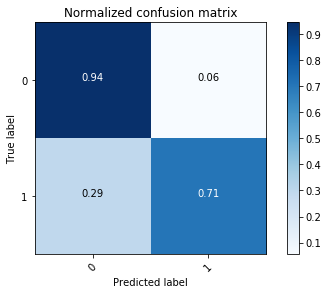

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      8590
           1       0.86      0.71      0.78      4243

   micro avg       0.87      0.87      0.87     12833
   macro avg       0.87      0.83      0.84     12833
weighted avg       0.87      0.87      0.86     12833

2019-04-07 21:28:29


Iteration: 1
[ 2  4 16 17 19  8  0 18  9 13 11 12  6 14  5  7]
[1, 3, 10, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.94 0.06]
 [0.21 0.79]]


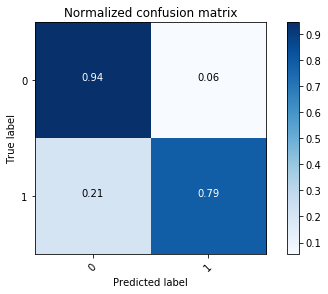

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      9030
           1       0.88      0.79      0.83      4754

   micro avg       0.89      0.89      0.89     13784
   macro avg       0.89      0.87      0.88     13784
weighted avg       0.89      0.89      0.89     13784

2019-04-07 21:28:31


Iteration: 2
[11  3  9  5 15 10  7 14  8  0 12 18 16 19 17  6]
[1, 2, 4, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.97 0.03]
 [0.33 0.67]]


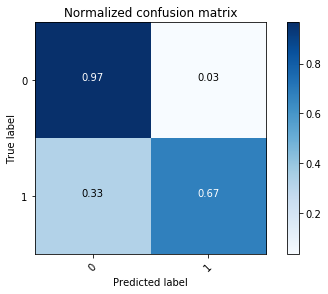

              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7011
           1       0.93      0.67      0.78      4639

   micro avg       0.85      0.85      0.85     11650
   macro avg       0.87      0.82      0.83     11650
weighted avg       0.86      0.85      0.84     11650

2019-04-07 21:28:32


Iteration: 3
[17  3 14  0  6  1 18 11  8  2  9  4 16  5 12 10]
[7, 13, 15, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.93 0.07]
 [0.24 0.76]]


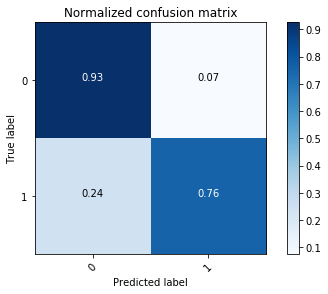

              precision    recall  f1-score   support

           0       0.86      0.93      0.89      6419
           1       0.86      0.76      0.81      3859

   micro avg       0.86      0.86      0.86     10278
   macro avg       0.86      0.84      0.85     10278
weighted avg       0.86      0.86      0.86     10278

2019-04-07 21:28:34


Iteration: 4
[12  7 18  3  8  5 15  6  1  4 13 19  9 14 16 11]
[0, 2, 10, 17]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.81 0.19]
 [0.2  0.8 ]]


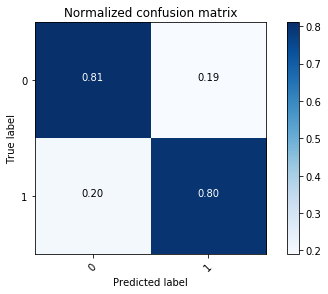

              precision    recall  f1-score   support

           0       0.88      0.81      0.84      8563
           1       0.69      0.80      0.74      4505

   micro avg       0.81      0.81      0.81     13068
   macro avg       0.79      0.80      0.79     13068
weighted avg       0.82      0.81      0.81     13068

2019-04-07 21:28:36


Iteration: 5
[ 9  3 11  7  4  5  1 15  0 14  2 18 16  8 19  6]
[10, 12, 13, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.78 0.22]
 [0.16 0.84]]


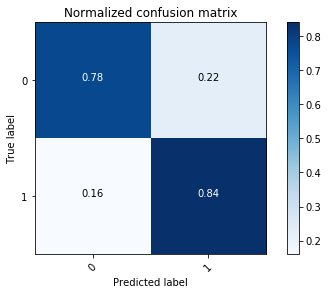

              precision    recall  f1-score   support

           0       0.89      0.78      0.83      6910
           1       0.69      0.84      0.75      4013

   micro avg       0.80      0.80      0.80     10923
   macro avg       0.79      0.81      0.79     10923
weighted avg       0.82      0.80      0.80     10923

2019-04-07 21:28:37


Iteration: 6
[12 10  5 16 13  3  8 18  7  6 15  1 11  9  4 17]
[0, 2, 14, 19]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.88 0.12]
 [0.2  0.8 ]]


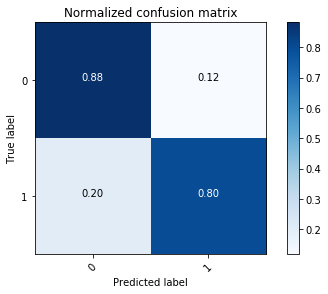

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7085
           1       0.80      0.80      0.80      4268

   micro avg       0.85      0.85      0.85     11353
   macro avg       0.84      0.84      0.84     11353
weighted avg       0.85      0.85      0.85     11353

2019-04-07 21:28:39


Iteration: 7
[ 2  1  8 15 19 13  0 16 14  7  4 10  6 12 17  3]
[5, 9, 11, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.91 0.09]
 [0.41 0.59]]


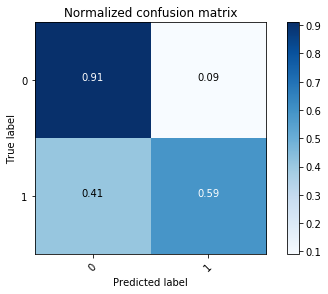

              precision    recall  f1-score   support

           0       0.79      0.91      0.85      6687
           1       0.79      0.59      0.68      3951

   micro avg       0.79      0.79      0.79     10638
   macro avg       0.79      0.75      0.76     10638
weighted avg       0.79      0.79      0.78     10638

2019-04-07 21:28:41


Iteration: 8
[ 5 19  3  0  9  7 10 15  4 13  6 11  2 16 14  1]
[8, 12, 17, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.8  0.2 ]
 [0.19 0.81]]


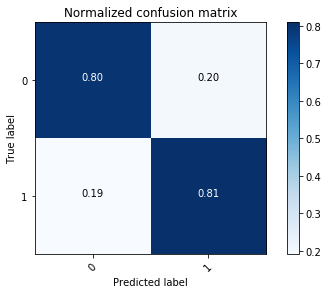

              precision    recall  f1-score   support

           0       0.90      0.80      0.85      8045
           1       0.64      0.81      0.71      3555

   micro avg       0.80      0.80      0.80     11600
   macro avg       0.77      0.80      0.78     11600
weighted avg       0.82      0.80      0.81     11600

2019-04-07 21:28:43


Iteration: 9
[10 19  2 13  6  9 14  3 16  0  4  1 15  7  8 12]
[5, 11, 17, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.76 0.24]
 [0.27 0.73]]


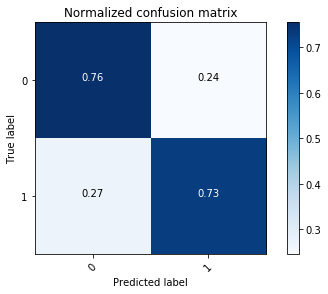

              precision    recall  f1-score   support

           0       0.85      0.76      0.80      7813
           1       0.59      0.73      0.65      3858

   micro avg       0.75      0.75      0.75     11671
   macro avg       0.72      0.74      0.73     11671
weighted avg       0.76      0.75      0.75     11671

2019-04-07 21:28:45

   sensitivity  specificity  accuracy
0     0.707990     0.944587  0.866360
1     0.787337     0.944850  0.890525
2     0.674714     0.965198  0.849528
3     0.758487     0.925689  0.862911
4     0.795782     0.809996  0.805096
5     0.839771     0.775832  0.799323
6     0.797563     0.881863  0.850172
7     0.588459     0.909675  0.790374
8     0.809001     0.797887  0.801293
9     0.725765     0.755280  0.745523
avg sensitivity: 0.7484868781960134
avg specificity: 0.8710857886585538
avg accuracy: 0.8261105416338965


In [8]:
## do multiple iterations with RF classifier
from sklearn.ensemble import RandomForestClassifier  # GradientBoostingClassifier,
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    
    ## model fitting
    model_rf = RandomForestClassifier(class_weight='balanced') #SVC(class_weight='balanced')  # probability=True
    model_rf.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_rf.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [9]:
model_rf

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

2019-04-07 21:40:25

Iteration: 0
[ 0 13 11  6  9  3 12  2  8 18 16  5 15 10  7  4]
[1, 14, 17, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.73 0.27]
 [0.07 0.93]]


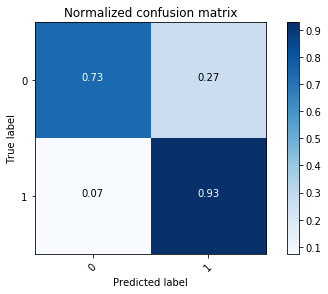

              precision    recall  f1-score   support

           0       0.94      0.73      0.82      7362
           1       0.70      0.93      0.79      4806

   micro avg       0.81      0.81      0.81     12168
   macro avg       0.82      0.83      0.81     12168
weighted avg       0.84      0.81      0.81     12168

2019-04-07 21:40:36


Iteration: 1
[ 4  9  1 16 17 18 12  5  0  2 14  3 13  8 10 15]
[6, 7, 11, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.9 0.1]
 [0.3 0.7]]


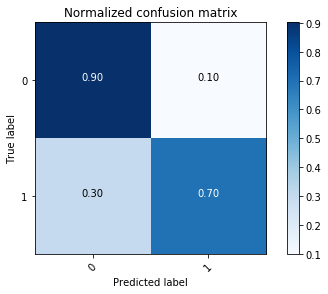

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      7046
           1       0.81      0.70      0.75      4324

   micro avg       0.82      0.82      0.82     11370
   macro avg       0.82      0.80      0.81     11370
weighted avg       0.82      0.82      0.82     11370

2019-04-07 21:40:45


Iteration: 2
[ 9 18 15 14  6  5  0  7  2  3 12 10  4 11 13  8]
[1, 16, 17, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.78 0.22]
 [0.18 0.82]]


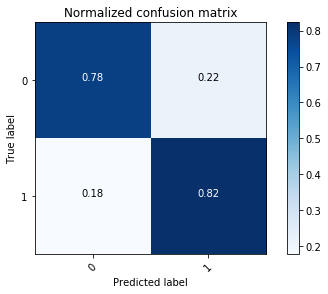

              precision    recall  f1-score   support

           0       0.86      0.78      0.82      7037
           1       0.73      0.82      0.77      4964

   micro avg       0.80      0.80      0.80     12001
   macro avg       0.79      0.80      0.80     12001
weighted avg       0.81      0.80      0.80     12001

2019-04-07 21:40:57


Iteration: 3
[ 9 19  6  5 11 17  2  0 12  3 14  4  1  8  7 10]
[13, 15, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.32 0.68]]


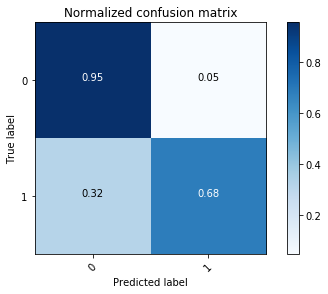

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7396
           1       0.87      0.68      0.77      3296

   micro avg       0.87      0.87      0.87     10692
   macro avg       0.87      0.82      0.84     10692
weighted avg       0.87      0.87      0.87     10692

2019-04-07 21:41:11


Iteration: 4
[19 15 12 16 14 17 10  7  4  9  2  3  0 11  8  1]
[5, 6, 13, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.94 0.06]
 [0.22 0.78]]


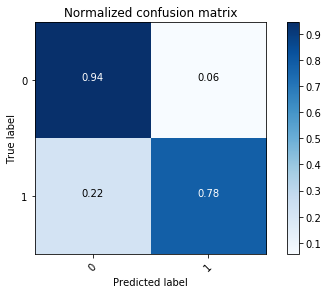

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7031
           1       0.87      0.78      0.82      3373

   micro avg       0.89      0.89      0.89     10404
   macro avg       0.88      0.86      0.87     10404
weighted avg       0.89      0.89      0.89     10404

2019-04-07 21:41:24


Iteration: 5
[11 19 17 10 15  7  2  9  1 14  4  6  3 16  0 18]
[5, 8, 12, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.92 0.08]
 [0.18 0.82]]


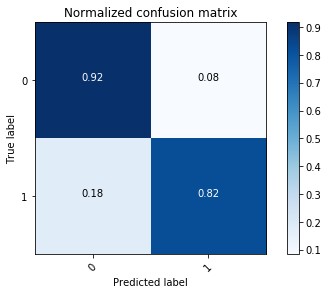

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      6360
           1       0.83      0.82      0.83      3162

   micro avg       0.89      0.89      0.89      9522
   macro avg       0.87      0.87      0.87      9522
weighted avg       0.88      0.89      0.89      9522

2019-04-07 21:41:37


Iteration: 6
[17  2  6 11 18 16 15 14  4 19  9 13  0 10  3  5]
[1, 7, 8, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.24 0.76]]


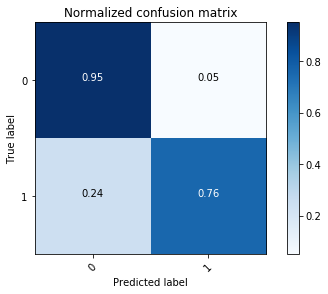

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      8321
           1       0.88      0.76      0.82      4008

   micro avg       0.89      0.89      0.89     12329
   macro avg       0.89      0.85      0.87     12329
weighted avg       0.89      0.89      0.89     12329

2019-04-07 21:41:47


Iteration: 7
[ 6  9 16 13 14 19  3  2  1  8  5 12 11  4 10  0]
[7, 15, 17, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.81 0.19]
 [0.18 0.82]]


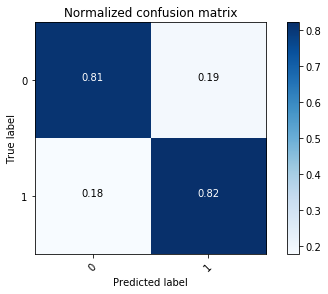

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      9122
           1       0.64      0.82      0.72      3786

   micro avg       0.81      0.81      0.81     12908
   macro avg       0.78      0.82      0.79     12908
weighted avg       0.84      0.81      0.82     12908

2019-04-07 21:41:58


Iteration: 8
[10 15 16  1 19  4 14  0  3 11 12  7 17  9 13  8]
[2, 5, 6, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.28 0.72]]


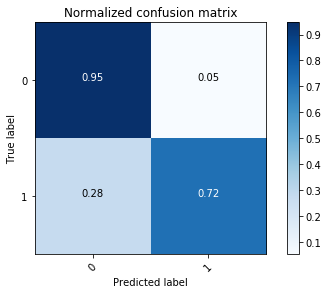

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      8344
           1       0.87      0.72      0.79      4044

   micro avg       0.87      0.87      0.87     12388
   macro avg       0.87      0.84      0.85     12388
weighted avg       0.87      0.87      0.87     12388

2019-04-07 21:42:12


Iteration: 9
[ 1 19  2 18  0  3 12  8  6 16  5  7 14 17 10 13]
[4, 9, 11, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.89 0.11]
 [0.31 0.69]]


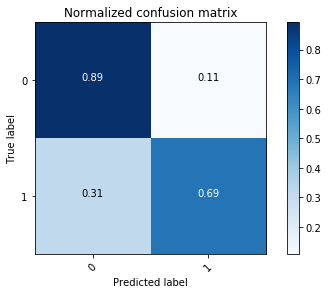

              precision    recall  f1-score   support

           0       0.81      0.89      0.85      6851
           1       0.80      0.69      0.74      4419

   micro avg       0.81      0.81      0.81     11270
   macro avg       0.81      0.79      0.80     11270
weighted avg       0.81      0.81      0.81     11270

2019-04-07 21:42:25

   sensitivity  specificity  accuracy
0     0.927174     0.734719  0.810733
1     0.698196     0.901504  0.824186
2     0.823127     0.780588  0.798183
3     0.683556     0.954840  0.871212
4     0.781500     0.943536  0.891003
5     0.821632     0.916824  0.885213
6     0.758733     0.950487  0.888150
7     0.821712     0.810239  0.813604
8     0.724530     0.946668  0.874152
9     0.685449     0.892424  0.811269
avg sensitivity: 0.7725608311669628
avg specificity: 0.8831830100011139
avg accuracy: 0.8467706900525311


In [10]:
## do multiple iterations with RF classifier - no. of trees specified
from sklearn.ensemble import RandomForestClassifier  # GradientBoostingClassifier,
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    
    ## model fitting
    model_rf = RandomForestClassifier(class_weight='balanced', n_estimators = 100) #SVC(class_weight='balanced')  # probability=True
    model_rf.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_rf.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-07 22:07:59

Iteration: 0
[14  5  6 19  0  3 12 18 16 17 10  4  2 15  1  9]
[7, 8, 11, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.92 0.08]
 [0.39 0.61]]


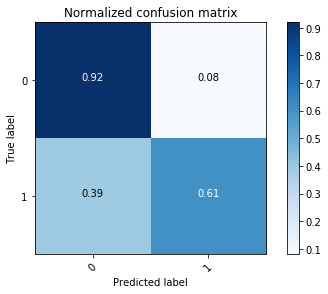

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      7142
           1       0.77      0.61      0.68      3149

   micro avg       0.82      0.82      0.82     10291
   macro avg       0.80      0.76      0.78     10291
weighted avg       0.82      0.82      0.82     10291

2019-04-07 22:08:30


Iteration: 1
[14  9 16 10 12 17 13 18  1 19  4 11  6  7 15  5]
[0, 2, 3, 8]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.92 0.08]
 [0.22 0.78]]


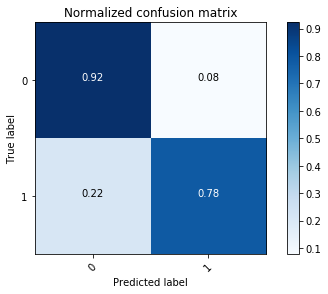

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      8518
           1       0.81      0.78      0.80      3654

   micro avg       0.88      0.88      0.88     12172
   macro avg       0.86      0.85      0.86     12172
weighted avg       0.88      0.88      0.88     12172

2019-04-07 22:09:01


Iteration: 2
[18  5 19 10 13 12  6  4 17  2 16  9  8 14  7 15]
[0, 1, 3, 11]
        0         1    2    3        4         5         6         7   \
0  0.16443  0.050336  0.0  0.0  0.04698  0.194631  0.060403  0.006711   

         8         9         10        11   12        13        14        15  
0  0.003356  0.053691  0.151007  0.053691  0.0  0.010067  0.053691  0.151007  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.89 0.11]
 [0.23 0.77]]


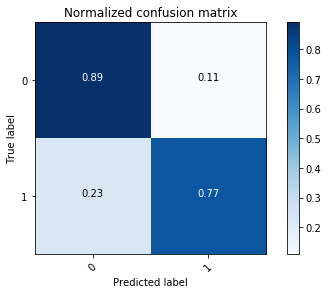

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      8297
           1       0.78      0.77      0.78      4083

   micro avg       0.85      0.85      0.85     12380
   macro avg       0.83      0.83      0.83     12380
weighted avg       0.85      0.85      0.85     12380

2019-04-07 22:09:28


Iteration: 3
[ 2 17 11  0  1 13  4  8  3 12 10  7 15  6 18 16]
[5, 9, 14, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.88 0.12]
 [0.15 0.85]]


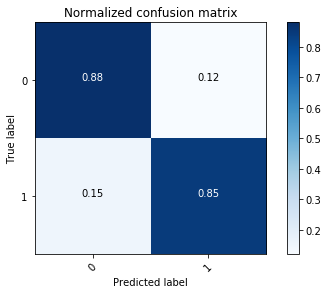

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      5585
           1       0.85      0.85      0.85      4467

   micro avg       0.86      0.86      0.86     10052
   macro avg       0.86      0.86      0.86     10052
weighted avg       0.86      0.86      0.86     10052

2019-04-07 22:10:01


Iteration: 4
[19  2  8 14  4  9  6  1 11  0 17 10  5 15  3 12]
[7, 13, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.98 0.02]
 [0.4  0.6 ]]


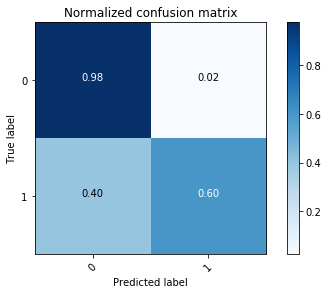

              precision    recall  f1-score   support

           0       0.84      0.98      0.90      7184
           1       0.93      0.60      0.73      3384

   micro avg       0.86      0.86      0.86     10568
   macro avg       0.88      0.79      0.81     10568
weighted avg       0.87      0.86      0.85     10568

2019-04-07 22:10:28


Iteration: 5
[14  0  5 16  7  2 13  3 15 18  1 12 11 17  8 19]
[4, 6, 9, 10]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.96 0.04]
 [0.25 0.75]]


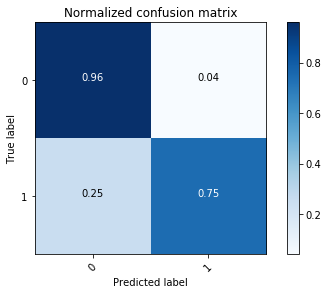

              precision    recall  f1-score   support

           0       0.84      0.96      0.89      6868
           1       0.93      0.75      0.83      5040

   micro avg       0.87      0.87      0.87     11908
   macro avg       0.88      0.85      0.86     11908
weighted avg       0.88      0.87      0.87     11908

2019-04-07 22:11:01


Iteration: 6
[11  2 18 10  1  9 14  4 13  3 17 15  5  0 19  6]
[7, 8, 12, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.36 0.64]]


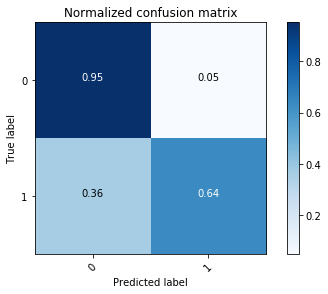

              precision    recall  f1-score   support

           0       0.85      0.95      0.90      7828
           1       0.86      0.64      0.73      3589

   micro avg       0.85      0.85      0.85     11417
   macro avg       0.85      0.79      0.81     11417
weighted avg       0.85      0.85      0.85     11417

2019-04-07 22:11:28


Iteration: 7
[ 6  0 14  7 16  5 19 15  8  2  9 18 13 11 12 17]
[1, 3, 4, 10]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.19 0.81]]


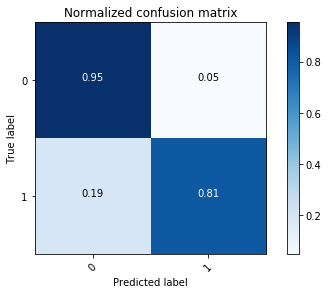

              precision    recall  f1-score   support

           0       0.88      0.95      0.92      7950
           1       0.92      0.81      0.86      5311

   micro avg       0.90      0.90      0.90     13261
   macro avg       0.90      0.88      0.89     13261
weighted avg       0.90      0.90      0.89     13261

2019-04-07 22:11:59


Iteration: 8
[13  3  4 10  7  0 18  6  1  2 17 12  9 15 14  8]
[5, 11, 16, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.87 0.13]
 [0.31 0.69]]


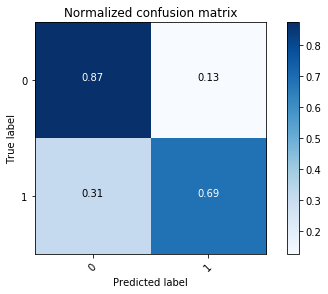

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      5957
           1       0.80      0.69      0.74      4381

   micro avg       0.79      0.79      0.79     10338
   macro avg       0.80      0.78      0.78     10338
weighted avg       0.80      0.79      0.79     10338

2019-04-07 22:12:25


Iteration: 9
[ 3 14 11 17  9 15 12  8  4  7 16 13 10  5  0 18]
[1, 2, 6, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Normalized confusion matrix
[[0.95 0.05]
 [0.21 0.79]]


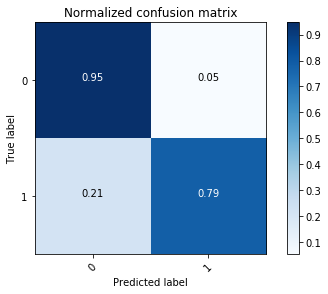

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7555
           1       0.91      0.79      0.84      5075

   micro avg       0.88      0.88      0.88     12630
   macro avg       0.89      0.87      0.87     12630
weighted avg       0.88      0.88      0.88     12630

2019-04-07 22:12:56

   sensitivity  specificity  accuracy
0     0.605907     0.919490  0.823535
1     0.784072     0.922282  0.880792
2     0.774675     0.891165  0.852746
3     0.845534     0.879857  0.864604
4     0.598700     0.977450  0.856170
5     0.745437     0.959522  0.868912
6     0.635274     0.951967  0.852413
7     0.809640     0.953333  0.895785
8     0.686373     0.874433  0.794738
9     0.785616     0.947055  0.882185
avg sensitivity: 0.7271228113745829
avg specificity: 0.9276556117239669
avg accuracy: 0.857187959125414


In [11]:
## do multiple iterations with RF classifier - more trees
from sklearn.ensemble import RandomForestClassifier  # GradientBoostingClassifier,
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    
    ## model fitting
    model_rf = RandomForestClassifier(class_weight='balanced', n_estimators = 301) #SVC(class_weight='balanced')  # probability=True
    model_rf.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_rf.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
## optimise RF further using predict_proba & grid search

2019-04-07 22:12:56

Iteration: 0
[ 4 15 10 18 13 19  8  2  3 17  5  1 14  6 11 12]
[0, 7, 9, 16]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.34 0.66]]


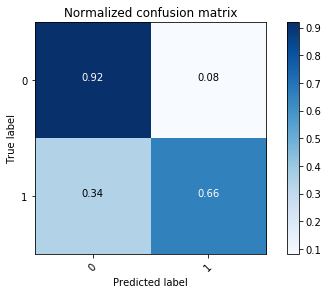

              precision    recall  f1-score   support

           0       0.83      0.92      0.87      7223
           1       0.81      0.66      0.73      3885

   micro avg       0.83      0.83      0.83     11108
   macro avg       0.82      0.79      0.80     11108
weighted avg       0.83      0.83      0.82     11108

2019-04-07 22:13:42


Iteration: 1
[ 7 11 15 13  0  8  5 10  6 16  1 12  3 19  2 18]
[4, 9, 14, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.7  0.3 ]
 [0.16 0.84]]


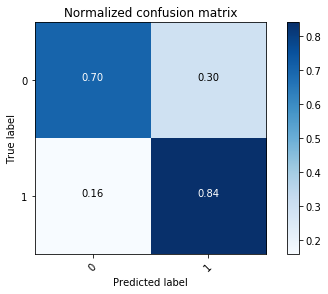

              precision    recall  f1-score   support

           0       0.87      0.70      0.78      6930
           1       0.65      0.84      0.73      4536

   micro avg       0.76      0.76      0.76     11466
   macro avg       0.76      0.77      0.76     11466
weighted avg       0.78      0.76      0.76     11466

2019-04-07 22:14:25


Iteration: 2
[10  1 17  6  4 13  9 19  7  2 11  5  3  0 18 15]
[8, 12, 14, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.25 0.75]]


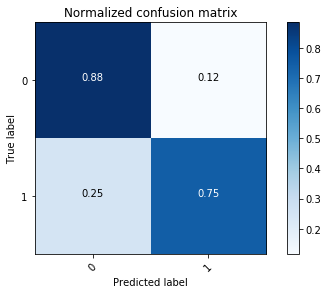

              precision    recall  f1-score   support

           0       0.89      0.88      0.89      7690
           1       0.75      0.75      0.75      3467

   micro avg       0.84      0.84      0.84     11157
   macro avg       0.82      0.82      0.82     11157
weighted avg       0.84      0.84      0.84     11157

2019-04-07 22:15:08


Iteration: 3
[ 5  6  4  9  2  8 17  1  7 11 16 10 12 13  0 15]
[3, 14, 18, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.16 0.84]]


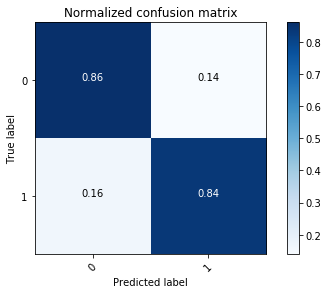

              precision    recall  f1-score   support

           0       0.90      0.86      0.88      7064
           1       0.78      0.84      0.81      4152

   micro avg       0.85      0.85      0.85     11216
   macro avg       0.84      0.85      0.84     11216
weighted avg       0.85      0.85      0.85     11216

2019-04-07 22:15:55


Iteration: 4
[10  5  3  4  7  0  2 19 14 15  9 13  6 18  1 12]
[8, 11, 16, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.73 0.27]
 [0.33 0.67]]


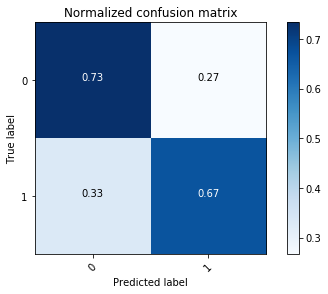

              precision    recall  f1-score   support

           0       0.83      0.73      0.78      7942
           1       0.54      0.67      0.60      3711

   micro avg       0.71      0.71      0.71     11653
   macro avg       0.68      0.70      0.69     11653
weighted avg       0.73      0.71      0.72     11653

2019-04-07 22:16:40


Iteration: 5
[ 2 19  1  4 16 17 11  8 15  5 12  0 14 10 18 13]
[3, 6, 7, 9]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.28 0.72]]


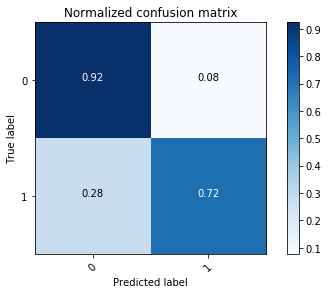

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7872
           1       0.83      0.72      0.77      4102

   micro avg       0.85      0.85      0.85     11974
   macro avg       0.85      0.82      0.83     11974
weighted avg       0.85      0.85      0.85     11974

2019-04-07 22:17:23


Iteration: 6
[12 17 18  5  3 11 15 16  0  1  8  2 19  9  7  6]
[4, 10, 13, 14]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9 0.1]
 [0.2 0.8]]


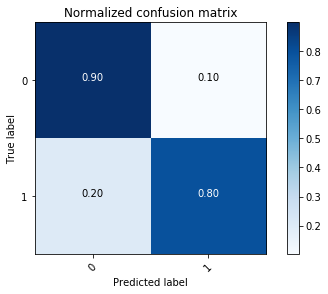

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      6588
           1       0.84      0.80      0.82      4297

   micro avg       0.86      0.86      0.86     10885
   macro avg       0.85      0.85      0.85     10885
weighted avg       0.86      0.86      0.86     10885

2019-04-07 22:18:07


Iteration: 7
[11 15 14  6 19 18  4 10  3 12 16  8  7  1  0  5]
[2, 9, 13, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.76 0.24]
 [0.23 0.77]]


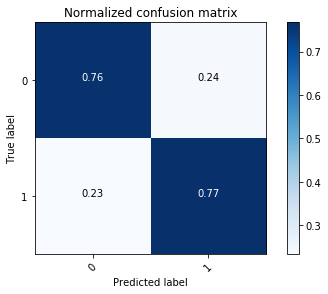

              precision    recall  f1-score   support

           0       0.84      0.76      0.80      6629
           1       0.66      0.77      0.71      4032

   micro avg       0.76      0.76      0.76     10661
   macro avg       0.75      0.76      0.76     10661
weighted avg       0.77      0.76      0.77     10661

2019-04-07 22:18:54


Iteration: 8
[ 5 11  3 17  8 18 19 13  9  2  6  4  7 16 14  1]
[0, 10, 12, 15]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.16 0.84]]


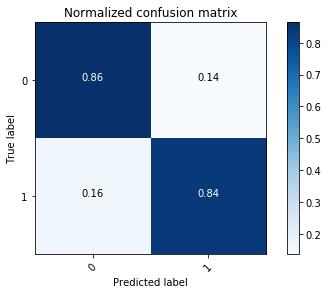

              precision    recall  f1-score   support

           0       0.92      0.86      0.89      8182
           1       0.75      0.84      0.79      3999

   micro avg       0.86      0.86      0.86     12181
   macro avg       0.83      0.85      0.84     12181
weighted avg       0.86      0.86      0.86     12181

2019-04-07 22:19:40


Iteration: 9
[ 8 13  5  2 19 12  7  4 16 11 17 10  3  1  0  6]
[9, 14, 15, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.89 0.11]
 [0.22 0.78]]


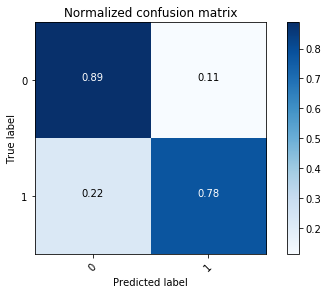

              precision    recall  f1-score   support

           0       0.89      0.89      0.89      7858
           1       0.77      0.78      0.77      3757

   micro avg       0.85      0.85      0.85     11615
   macro avg       0.83      0.83      0.83     11615
weighted avg       0.85      0.85      0.85     11615

2019-04-07 22:20:23

   sensitivity  specificity  accuracy
0     0.656628     0.919147  0.827332
1     0.840388     0.702886  0.757282
2     0.747909     0.884655  0.842162
3     0.835019     0.860136  0.850838
4     0.669361     0.733568  0.713121
5     0.718430     0.923399  0.853182
6     0.795904     0.898300  0.857878
7     0.767113     0.761502  0.763624
8     0.836709     0.863970  0.855020
9     0.776151     0.887249  0.851313
avg sensitivity: 0.7643613154818449
avg specificity: 0.8434813011233906
avg accuracy: 0.8171752301376103


In [12]:
#######################################################################################
## do multiple iterations with adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier  # GradientBoostingClassifier,

sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    
    ## model fitting
    rng = np.random.RandomState(1)
    model_rf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),n_estimators=301, random_state=rng) #SVC(class_weight='balanced')  # probability=True
    model_rf.fit(X_train_scaled, y_train1)
    
    
    ## predict on test data - check metrics
    y_pred = model_rf.predict(X_test_scaled)
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
## further optimisation required

In [ ]:
##########  ensemble of SVCs ###############

In [17]:
def modelFitPredict(X_train, y_train, X_test):
    # ensemble model fit
    model1 = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced')  #probability=True,
    model2 = SVC(kernel='rbf', C=5,gamma=0.01,class_weight='balanced')
    model3 = SVC(kernel='rbf', C=1,gamma=0.01,class_weight='balanced')  #probability=True,
    model4 = SVC(kernel='rbf',C=1,gamma=0.1,class_weight='balanced')   #probability=True,
    model5 = SVC(kernel='rbf',C=0.1,gamma=0.1,class_weight='balanced')  #probability=True,
    model6 = SVC(kernel='rbf',C=0.5, gamma=0.1,class_weight='balanced')         #probability=True,
    model7 = SVC(kernel='linear',class_weight='balanced')                 #probability=True,
    
    model1.fit(X_train, y_train)
    model2.fit(X_train, y_train)
    model3.fit(X_train, y_train)
    model4.fit(X_train, y_train)
    model5.fit(X_train, y_train)
    model6.fit(X_train, y_train)
    model7.fit(X_train, y_train)
    
    # model prediction - majority voting
    pred1 = pd.DataFrame(model1.predict(X_test)) 
    pred2 = pd.DataFrame(model2.predict(X_test))
    pred3 = pd.DataFrame(model3.predict(X_test))
    pred4 = pd.DataFrame(model4.predict(X_test))
    pred5 = pd.DataFrame(model5.predict(X_test))
    pred6 = pd.DataFrame(model6.predict(X_test))
    pred7 = pd.DataFrame(model7.predict(X_test))
    pred = pd.DataFrame()  #pd.concat([pred1,pred2,pred3,pred4,pred5,pred6,pred7], axis=1)
    pred = pred1 + pred2 + pred3 + pred4 + pred5 + pred6 + pred7
    pred.columns = ['ensemble_sum']
    pred['y_pred'] = np.where(pred['ensemble_sum'] >= 4, 1, 0)
    print(pred.head(1))
    return pred['y_pred']

2019-04-08 10:32:35

Iteration: 0
[11 14  0 10  6 13  9 19 15  1  3 18  7 12  2  8]
[4, 5, 16, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11669, 1) , pred: (11669,)
Normalized confusion matrix
[[0.69 0.31]
 [0.12 0.88]]


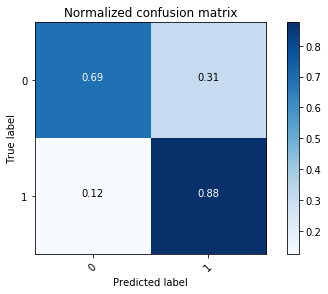

              precision    recall  f1-score   support

           0       0.90      0.69      0.78      7157
           1       0.64      0.88      0.74      4512

   micro avg       0.76      0.76      0.76     11669
   macro avg       0.77      0.78      0.76     11669
weighted avg       0.80      0.76      0.76     11669

2019-04-08 10:46:31


Iteration: 1
[12 19 10  6 11 18 14  0  3  1  4 15  9  8 17 16]
[2, 5, 7, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             0       0
test: (10966, 1) , pred: (10966,)
Normalized confusion matrix
[[0.91 0.09]
 [0.15 0.85]]


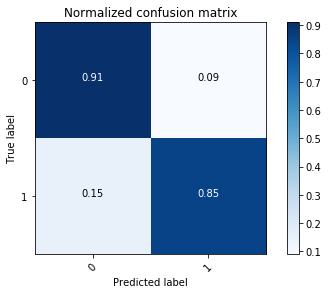

              precision    recall  f1-score   support

           0       0.92      0.91      0.92      7228
           1       0.83      0.85      0.84      3738

   micro avg       0.89      0.89      0.89     10966
   macro avg       0.87      0.88      0.88     10966
weighted avg       0.89      0.89      0.89     10966

2019-04-08 11:04:05


Iteration: 2
[15  0 14  8 16 12  9  2 19  5  1  7 18  4 13  6]
[3, 10, 11, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (12725, 1) , pred: (12725,)
Normalized confusion matrix
[[0.68 0.32]
 [0.14 0.86]]


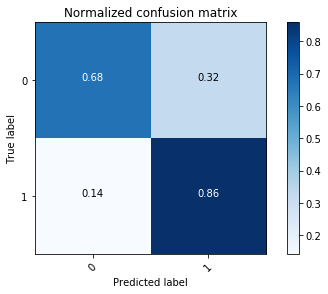

              precision    recall  f1-score   support

           0       0.90      0.68      0.77      8265
           1       0.59      0.86      0.70      4460

   micro avg       0.74      0.74      0.74     12725
   macro avg       0.74      0.77      0.73     12725
weighted avg       0.79      0.74      0.75     12725

2019-04-08 11:15:42


Iteration: 3
[18  7 16 17 11 19  6 14  9 10  8 13 15 12  1  2]
[0, 3, 4, 5]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11413, 1) , pred: (11413,)
Normalized confusion matrix
[[0.81 0.19]
 [0.06 0.94]]


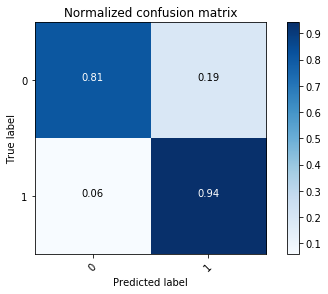

              precision    recall  f1-score   support

           0       0.96      0.81      0.88      7254
           1       0.74      0.94      0.83      4159

   micro avg       0.86      0.86      0.86     11413
   macro avg       0.85      0.88      0.85     11413
weighted avg       0.88      0.86      0.86     11413

2019-04-08 11:30:59


Iteration: 4
[14 17  3  8  4  1  0 16  5 11  7 18  2 12 13  6]
[9, 10, 15, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             0       0
test: (11274, 1) , pred: (11274,)
Normalized confusion matrix
[[0.85 0.15]
 [0.09 0.91]]


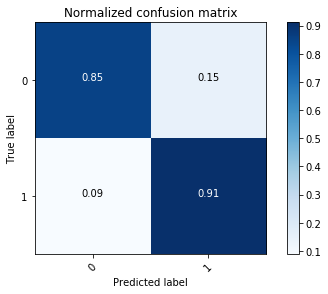

              precision    recall  f1-score   support

           0       0.92      0.85      0.89      6304
           1       0.83      0.91      0.87      4970

   micro avg       0.88      0.88      0.88     11274
   macro avg       0.88      0.88      0.88     11274
weighted avg       0.88      0.88      0.88     11274

2019-04-08 11:46:07


Iteration: 5
[10 19  0  7 15 13 14 18  8  1 17 12  9  2 16  3]
[4, 5, 6, 11]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11523, 1) , pred: (11523,)
Normalized confusion matrix
[[0.82 0.18]
 [0.17 0.83]]


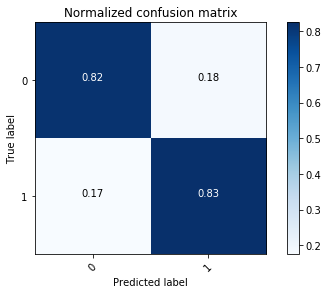

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      7196
           1       0.73      0.83      0.77      4327

   micro avg       0.82      0.82      0.82     11523
   macro avg       0.81      0.82      0.81     11523
weighted avg       0.83      0.82      0.82     11523

2019-04-08 12:02:04


Iteration: 6
[ 3 17 15  7  2 16  1  6  4 19 13 11 10  8  9 12]
[0, 5, 14, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11336, 1) , pred: (11336,)
Normalized confusion matrix
[[0.81 0.19]
 [0.05 0.95]]


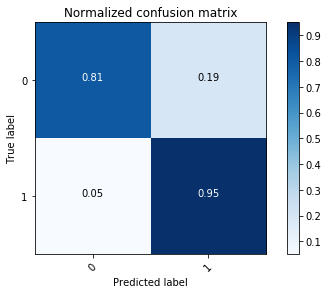

              precision    recall  f1-score   support

           0       0.97      0.81      0.88      7901
           1       0.68      0.95      0.79      3435

   micro avg       0.85      0.85      0.85     11336
   macro avg       0.83      0.88      0.84     11336
weighted avg       0.89      0.85      0.86     11336

2019-04-08 12:19:25


Iteration: 7
[15  6 18 17  2  1  4 19  0 10 13  8  9 16 11  5]
[3, 7, 12, 14]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11989, 1) , pred: (11989,)
Normalized confusion matrix
[[0.83 0.17]
 [0.07 0.93]]


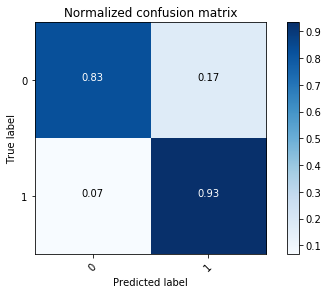

              precision    recall  f1-score   support

           0       0.96      0.83      0.89      8265
           1       0.71      0.93      0.80      3724

   micro avg       0.86      0.86      0.86     11989
   macro avg       0.84      0.88      0.85     11989
weighted avg       0.88      0.86      0.86     11989

2019-04-08 12:32:17


Iteration: 8
[19  6 10 12  0  4  7 15  3  8 16 13  9 18 17  2]
[1, 5, 11, 14]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             0       0
test: (12140, 1) , pred: (12140,)
Normalized confusion matrix
[[0.81 0.19]
 [0.14 0.86]]


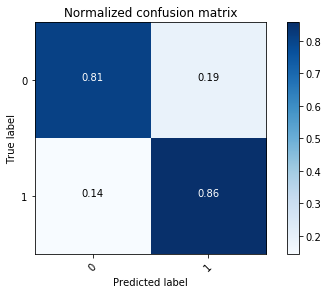

              precision    recall  f1-score   support

           0       0.91      0.81      0.86      7951
           1       0.70      0.86      0.77      4189

   micro avg       0.82      0.82      0.82     12140
   macro avg       0.81      0.83      0.81     12140
weighted avg       0.84      0.82      0.83     12140

2019-04-08 12:42:54


Iteration: 9
[14 17 13 19  4 18 11  2 15  7  3  8  6  1 12 16]
[0, 5, 9, 10]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A 

   ensemble_sum  y_pred
0             7       1
test: (11177, 1) , pred: (11177,)
Normalized confusion matrix
[[0.85 0.15]
 [0.08 0.92]]


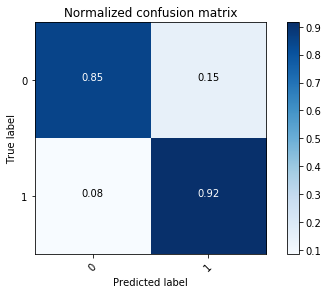

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6813
           1       0.79      0.92      0.85      4364

   micro avg       0.87      0.87      0.87     11177
   macro avg       0.87      0.88      0.87     11177
weighted avg       0.88      0.87      0.88     11177

2019-04-08 12:54:09

   sensitivity  specificity  accuracy
0     0.875665     0.688137  0.760648
1     0.847512     0.909934  0.888656
2     0.858072     0.675378  0.739411
3     0.941332     0.809898  0.857794
4     0.911268     0.851681  0.877949
5     0.825052     0.816426  0.819665
6     0.949345     0.808758  0.851359
7     0.933136     0.825892  0.859204
8     0.856768     0.806817  0.824053
9     0.915674     0.848525  0.874743
avg sensitivity: 0.8913823146180924
avg specificity: 0.804144676482289
avg accuracy: 0.8353480618454538


In [18]:
# input parameters: 10,0.01 ; #1,0.01
## do multiple iterations
sensitivity = []
specificity = []
accuracy = []
print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

for i in range(10):
    print('')    
    print("Iteration: " + str(i))
    
    Train, Test = CreateTrainTestID(dfull)
    X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
    print('')
    
    ### data scaling ###
    scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
    X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
    X_test_scaled = scaler.transform(X_test)
    
    ## model fitting & prediction
    y_pred = modelFitPredict(X_train_scaled, y_train1, X_test_scaled)
    print('test: ' + str(y_test.shape) + ' , pred: ' + str(y_pred.shape))
    
    
    #####    Compute confusion matrix     ####
    class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)
    #print(cnf_matrix)
    # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
    plt.show()
    
    ## print metrics
    print(classification_report(y_test, y_pred, target_names=class_names))
    #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
    p = precision_recall_fscore_support(y_test,y_pred)
    #sen = p[1][1]
    #spec = p[1][0]
    #print('sen: ' + str(sen) +' , spec: ' + str(spec))
    sensitivity.append(p[1][1])
    specificity.append(p[1][0])
    accuracy.append(accuracy_score(y_test,y_pred))
    
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    print('')

sensitivity = pd.DataFrame(sensitivity)
specificity = pd.DataFrame(specificity)
accuracy = pd.DataFrame(accuracy)
metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
metrics.columns = ['sensitivity', 'specificity', 'accuracy']
print(metrics)
print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
print('avg specificity: ' + str(metrics.specificity.mean()))
print('avg accuracy: ' + str(metrics.accuracy.mean()))    

In [ ]:
## test the performance of each of the SVCs ##

In [19]:
def modelFitPredict(X_train, y_train, X_test, model):
    #model1 = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [20]:
## run the validation
def validateSVC(dfull, model):
    sensitivity = []
    specificity = []
    accuracy = []
    print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    
    for i in range(10):
        print('') 
        print("Iteration: " + str(i))
        
        Train, Test = CreateTrainTestID(dfull)
        X_train1, y_train1, X_test, y_test = createXYsets(Train,Test)
        print('')
        ### data scaling ###
        scaler = StandardScaler().fit(X_train1)  # StandardScaler();  MinMaxScaler()
        X_train_scaled = scaler.transform(X_train1)    # fit_transform(X_train1)
        X_test_scaled = scaler.transform(X_test)
        
        ## model fitting & prediction
        y_pred = modelFitPredict(X_train_scaled, y_train1, X_test_scaled, model)
        #print('test: ' + str(y_test.shape) + ' , pred: ' + str(y_pred.shape))
        
        
        ####    Compute confusion matrix     ####
        class_names = ['0','1'] #['wake','sleep_stage_1','sleep_stage_2']  # wake, SS1, SS2  ; # '0','1','2'
        cnf_matrix = confusion_matrix(y_test, y_pred)
        np.set_printoptions(precision=2)
        #print(cnf_matrix)
        # Plot normalized confusion matrix : normalisation shows nan for class'0' no signal has class=0 as true label
        plt.figure()
        plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
        plt.show()
        
        ## print metrics
        print(classification_report(y_test, y_pred, target_names=class_names))
        #print('accuracy: ' + str(accuracy_score(y_test,y_pred)))
        p = precision_recall_fscore_support(y_test,y_pred)
        #sen = p[1][1]
        #spec = p[1][0]
        #print('sen: ' + str(sen) +' , spec: ' + str(spec))
        sensitivity.append(p[1][1])
        specificity.append(p[1][0])
        accuracy.append(accuracy_score(y_test,y_pred))
        
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
        print('')
        
    sensitivity = pd.DataFrame(sensitivity)
    specificity = pd.DataFrame(specificity)
    accuracy = pd.DataFrame(accuracy)
    metrics = pd.concat([sensitivity, specificity, accuracy], axis=1)
    metrics.columns = ['sensitivity', 'specificity', 'accuracy']
    print(metrics)
    print('avg sensitivity: ' + str(metrics.sensitivity.mean()))
    print('avg specificity: ' + str(metrics.specificity.mean()))
    print('avg accuracy: ' + str(metrics.accuracy.mean()))    

2019-04-08 14:36:01

Iteration: 0
[15  5  8  2 13 12  0 16  9 17  7 14  1 18 11  4]
[3, 6, 10, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.06 0.94]]


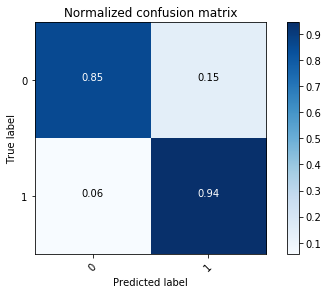

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      7154
           1       0.82      0.94      0.88      4878

   micro avg       0.89      0.89      0.89     12032
   macro avg       0.89      0.90      0.89     12032
weighted avg       0.90      0.89      0.89     12032

2019-04-08 14:37:42


Iteration: 1
[ 8 17 10 19 13 16 15  2  3 18  4 14 12  0  7  6]
[1, 5, 9, 11]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.17 0.83]]


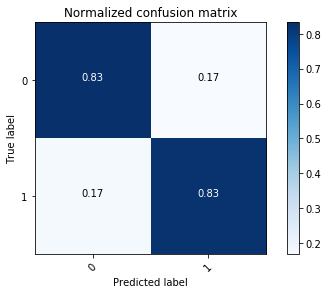

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      6916
           1       0.76      0.83      0.79      4516

   micro avg       0.83      0.83      0.83     11432
   macro avg       0.82      0.83      0.82     11432
weighted avg       0.83      0.83      0.83     11432

2019-04-08 14:39:03


Iteration: 2
[ 1 16 19 14  7 10  3  9  6 13 17 15 12  5  2  8]
[0, 4, 11, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.8  0.2 ]
 [0.19 0.81]]


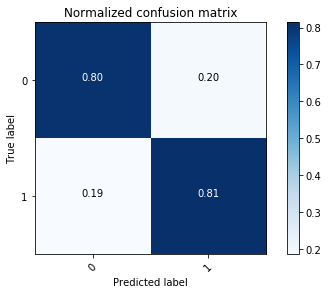

              precision    recall  f1-score   support

           0       0.89      0.80      0.84      7316
           1       0.69      0.81      0.75      3964

   micro avg       0.81      0.81      0.81     11280
   macro avg       0.79      0.81      0.80     11280
weighted avg       0.82      0.81      0.81     11280

2019-04-08 14:40:18


Iteration: 3
[ 3  2 16 11  9  6 15  5 13  0  8 17  7  4  1 14]
[10, 12, 18, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.07 0.93]]


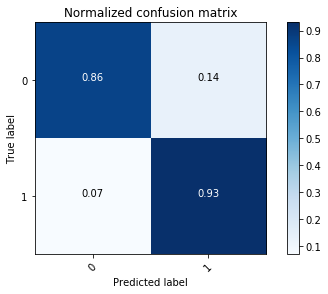

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      6429
           1       0.83      0.93      0.88      4694

   micro avg       0.89      0.89      0.89     11123
   macro avg       0.89      0.90      0.89     11123
weighted avg       0.90      0.89      0.89     11123

2019-04-08 14:41:40


Iteration: 4
[ 3 11 18 19 13  5 17 14  0 16  8 12 10  6  9 15]
[1, 2, 4, 7]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.92 0.08]
 [0.14 0.86]]


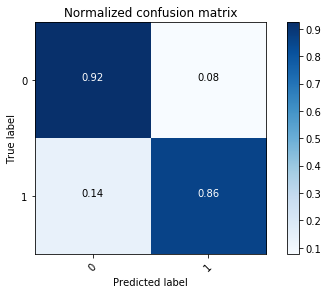

              precision    recall  f1-score   support

           0       0.91      0.92      0.92      8321
           1       0.87      0.86      0.87      5053

   micro avg       0.90      0.90      0.90     13374
   macro avg       0.89      0.89      0.89     13374
weighted avg       0.90      0.90      0.90     13374

2019-04-08 14:42:57


Iteration: 5
[ 3 19  5 15 13 11  2  8 14  9 18  1 12  7  4 16]
[0, 6, 10, 17]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.69 0.31]
 [0.04 0.96]]


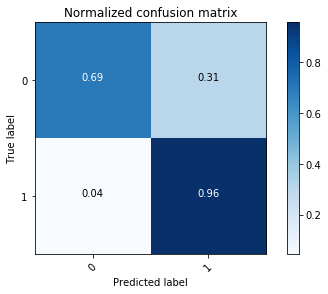

              precision    recall  f1-score   support

           0       0.97      0.69      0.81      8565
           1       0.61      0.96      0.74      4250

   micro avg       0.78      0.78      0.78     12815
   macro avg       0.79      0.82      0.78     12815
weighted avg       0.85      0.78      0.79     12815

2019-04-08 14:44:12


Iteration: 6
[14  2 17 15 10  3  8  0  6 13 12  4 19  7 18 16]
[1, 5, 9, 11]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.17 0.83]]


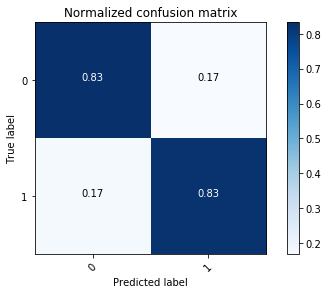

              precision    recall  f1-score   support

           0       0.88      0.83      0.86      6916
           1       0.76      0.83      0.79      4516

   micro avg       0.83      0.83      0.83     11432
   macro avg       0.82      0.83      0.82     11432
weighted avg       0.83      0.83      0.83     11432

2019-04-08 14:45:35


Iteration: 7
[ 3 12  5 16  2  9 18 13  8 11  6 10 17  0 14  1]
[4, 7, 15, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.08 0.92]]


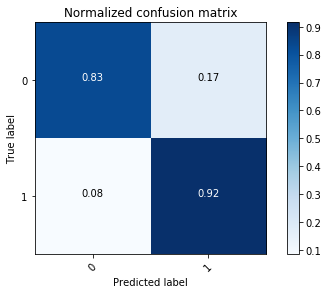

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      6861
           1       0.79      0.92      0.85      4742

   micro avg       0.87      0.87      0.87     11603
   macro avg       0.86      0.87      0.86     11603
weighted avg       0.88      0.87      0.87     11603

2019-04-08 14:47:06


Iteration: 8
[14  4 15  0  6 12  2 16  8 10  5  3  7 13 17 19]
[1, 9, 11, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.21 0.79]]


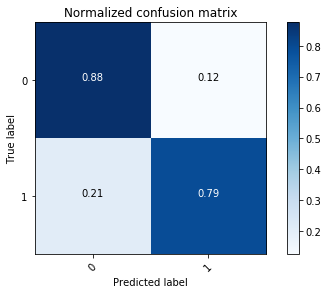

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7338
           1       0.79      0.79      0.79      4383

   micro avg       0.85      0.85      0.85     11721
   macro avg       0.83      0.83      0.83     11721
weighted avg       0.85      0.85      0.85     11721

2019-04-08 14:48:29


Iteration: 9
[ 2 12  8  6 10 14 17  1  0 18 11 15 13  5  3 19]
[4, 7, 9, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.93 0.07]
 [0.2  0.8 ]]


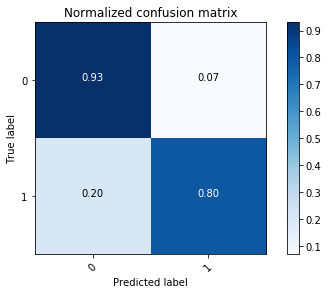

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      6652
           1       0.89      0.80      0.84      4582

   micro avg       0.88      0.88      0.88     11234
   macro avg       0.88      0.86      0.87     11234
weighted avg       0.88      0.88      0.87     11234

2019-04-08 14:49:55

   sensitivity  specificity  accuracy
0     0.943624     0.854906  0.890874
1     0.825066     0.832996  0.829864
2     0.813824     0.804265  0.807624
3     0.930763     0.863742  0.892026
4     0.858500     0.923327  0.898834
5     0.955294     0.694104  0.780726
6     0.825066     0.832996  0.829864
7     0.915858     0.830783  0.865552
8     0.793064     0.876261  0.845150
9     0.796377     0.930247  0.875645
avg sensitivity: 0.8657437938286833
avg specificity: 0.8443625514699871
avg accuracy: 0.8516157438797608


In [21]:
model1 = SVC(kernel='rbf', C=10, gamma=0.01, class_weight='balanced')
validateSVC(dfull, model1)

2019-04-08 15:34:38

Iteration: 0
[14  1  9  7  8 12 16 18 19 11  3  2 13 10  5 17]
[0, 4, 6, 15]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.07 0.93]]


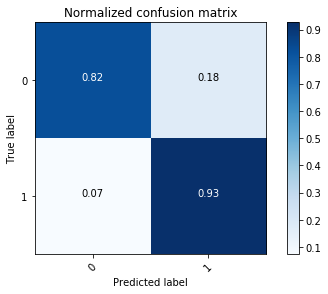

              precision    recall  f1-score   support

           0       0.96      0.82      0.89      8208
           1       0.72      0.93      0.81      4027

   micro avg       0.86      0.86      0.86     12235
   macro avg       0.84      0.88      0.85     12235
weighted avg       0.88      0.86      0.86     12235

2019-04-08 15:36:11


Iteration: 1
[ 5  1 13 15  3  0  4 19 17 12 18  8  9 16  6  2]
[7, 10, 11, 14]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.17 0.83]]


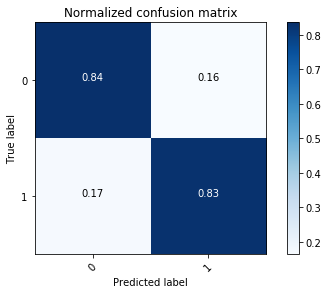

              precision    recall  f1-score   support

           0       0.91      0.84      0.87      8290
           1       0.72      0.83      0.77      4203

   micro avg       0.83      0.83      0.83     12493
   macro avg       0.81      0.83      0.82     12493
weighted avg       0.84      0.83      0.84     12493

2019-04-08 15:37:32


Iteration: 2
[ 0  3  2 16 12 14  6 19  9 17  4  8 13 11  1 18]
[5, 7, 10, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.09 0.91]]


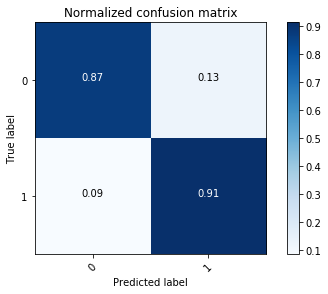

              precision    recall  f1-score   support

           0       0.95      0.87      0.91      8495
           1       0.79      0.91      0.85      4299

   micro avg       0.89      0.89      0.89     12794
   macro avg       0.87      0.89      0.88     12794
weighted avg       0.90      0.89      0.89     12794

2019-04-08 15:38:58


Iteration: 3
[ 1 14  5  9  6 15 10 11 16 12 13 18  2 17  7  8]
[0, 3, 4, 19]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.77 0.23]
 [0.05 0.95]]


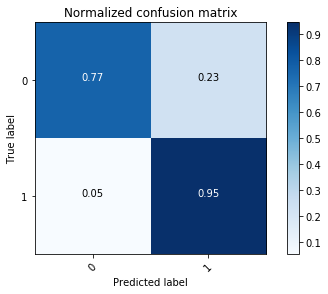

              precision    recall  f1-score   support

           0       0.95      0.77      0.85      6236
           1       0.75      0.95      0.84      4625

   micro avg       0.84      0.84      0.84     10861
   macro avg       0.85      0.86      0.84     10861
weighted avg       0.87      0.84      0.85     10861

2019-04-08 15:40:23


Iteration: 4
[16 18  9  0  4  5 14 13  3  7 12 15  8 19 10 11]
[1, 2, 6, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.76 0.24]
 [0.09 0.91]]


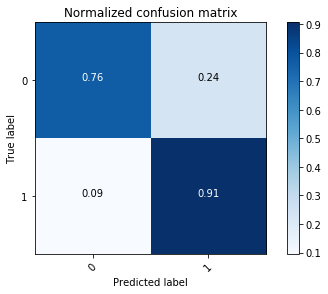

              precision    recall  f1-score   support

           0       0.94      0.76      0.84      9147
           1       0.66      0.91      0.77      4698

   micro avg       0.81      0.81      0.81     13845
   macro avg       0.80      0.83      0.80     13845
weighted avg       0.85      0.81      0.82     13845

2019-04-08 15:41:37


Iteration: 5
[19  7  4 16  2  6 12  1 13  8 10  5 15 18  0 14]
[3, 9, 11, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.64 0.36]
 [0.17 0.83]]


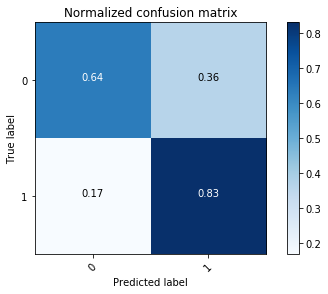

              precision    recall  f1-score   support

           0       0.87      0.64      0.73      7344
           1       0.56      0.83      0.67      4173

   micro avg       0.71      0.71      0.71     11517
   macro avg       0.72      0.73      0.70     11517
weighted avg       0.76      0.71      0.71     11517

2019-04-08 15:42:48


Iteration: 6
[ 4  0  7 15  8  2  3 12 10  5 11  6 16 19 17  9]
[1, 13, 14, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.89 0.11]
 [0.08 0.92]]


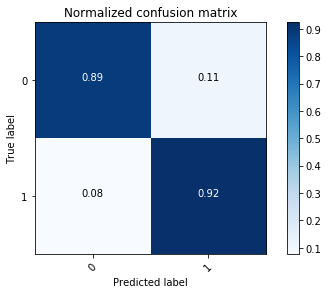

              precision    recall  f1-score   support

           0       0.96      0.89      0.92      7539
           1       0.80      0.92      0.86      3681

   micro avg       0.90      0.90      0.90     11220
   macro avg       0.88      0.91      0.89     11220
weighted avg       0.91      0.90      0.90     11220

2019-04-08 15:44:18


Iteration: 7
[10  5 15  3 17 12  8  9 19  0 13 14  4  7 11 18]
[1, 2, 6, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.94 0.06]
 [0.18 0.82]]


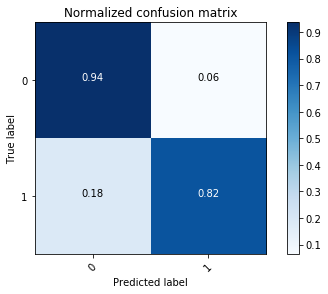

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      8731
           1       0.87      0.82      0.84      4622

   micro avg       0.89      0.89      0.89     13353
   macro avg       0.89      0.88      0.88     13353
weighted avg       0.89      0.89      0.89     13353

2019-04-08 15:45:39


Iteration: 8
[ 3  8  5 12 10  1 15  2 13  6  9 19 14  0 17  7]
[4, 11, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.27 0.73]]


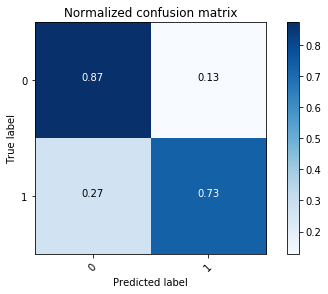

              precision    recall  f1-score   support

           0       0.85      0.87      0.86      7150
           1       0.77      0.73      0.75      4228

   micro avg       0.82      0.82      0.82     11378
   macro avg       0.81      0.80      0.81     11378
weighted avg       0.82      0.82      0.82     11378

2019-04-08 15:46:54


Iteration: 9
[ 2  3  7  5  4 16 10 19  1 14 17 15  6  8 13 11]
[0, 9, 12, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.11 0.89]]


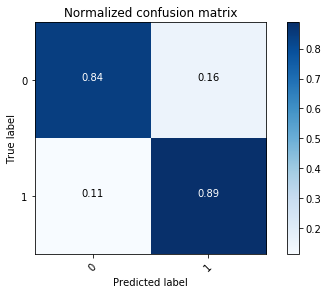

              precision    recall  f1-score   support

           0       0.93      0.84      0.89      6850
           1       0.75      0.89      0.82      3690

   micro avg       0.86      0.86      0.86     10540
   macro avg       0.84      0.87      0.85     10540
weighted avg       0.87      0.86      0.86     10540

2019-04-08 15:48:14

   sensitivity  specificity  accuracy
0     0.926744     0.823952  0.857785
1     0.828694     0.835947  0.833507
2     0.914166     0.874985  0.888151
3     0.946378     0.769403  0.844766
4     0.905705     0.763310  0.811629
5     0.831057     0.635485  0.706347
6     0.923390     0.886988  0.898930
7     0.816313     0.936433  0.894855
8     0.731552     0.872867  0.820355
9     0.887805     0.843358  0.858918
avg sensitivity: 0.8711804183674079
avg specificity: 0.8242728898866071
avg accuracy: 0.8415243110829722


In [23]:
model2 = SVC(kernel='rbf', C=5,gamma=0.01,class_weight='balanced')
validateSVC(dfull, model2)

2019-04-08 15:48:14

Iteration: 0
[ 7  9  8 15 13 10 14  3  1 18  0  6 16  2  4  5]
[11, 12, 17, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.55 0.45]
 [0.13 0.87]]


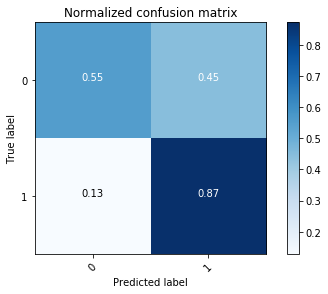

              precision    recall  f1-score   support

           0       0.86      0.55      0.67      6357
           1       0.57      0.87      0.69      4385

   micro avg       0.68      0.68      0.68     10742
   macro avg       0.72      0.71      0.68     10742
weighted avg       0.74      0.68      0.68     10742

2019-04-08 15:49:21


Iteration: 1
[16  5 17  2  8  6 14 12  4 15  9 10  0  3 19 11]
[1, 7, 13, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.95 0.05]
 [0.13 0.87]]


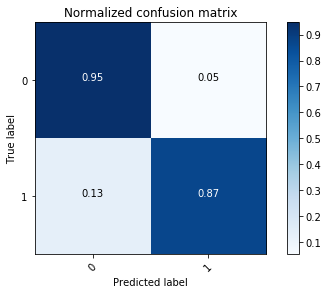

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      7677
           1       0.89      0.87      0.88      3803

   micro avg       0.92      0.92      0.92     11480
   macro avg       0.91      0.91      0.91     11480
weighted avg       0.92      0.92      0.92     11480

2019-04-08 15:50:48


Iteration: 2
[16 18  4 10  9  2 13 19 14 11  6  5  1 15  7  3]
[0, 8, 12, 17]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.65 0.35]
 [0.04 0.96]]


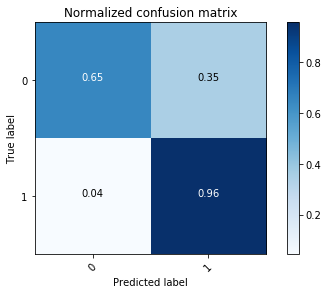

              precision    recall  f1-score   support

           0       0.97      0.65      0.78      7947
           1       0.54      0.96      0.69      3437

   micro avg       0.74      0.74      0.74     11384
   macro avg       0.76      0.80      0.74     11384
weighted avg       0.84      0.74      0.75     11384

2019-04-08 15:51:58


Iteration: 3
[ 7 18  0 11  5  3  2 14 15 19 16 12  1 13  8  6]
[4, 9, 10, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.7 0.3]
 [0.1 0.9]]


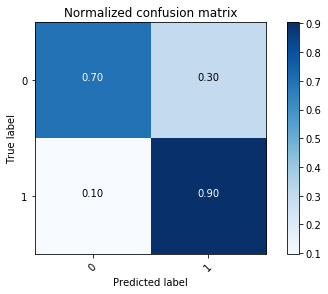

              precision    recall  f1-score   support

           0       0.91      0.70      0.79      6816
           1       0.69      0.90      0.78      5150

   micro avg       0.79      0.79      0.79     11966
   macro avg       0.80      0.80      0.79     11966
weighted avg       0.81      0.79      0.79     11966

2019-04-08 15:53:08


Iteration: 4
[11  0 16  2 15 10  4  9  8  3  6  1 12 14 17 18]
[5, 7, 13, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.08 0.92]]


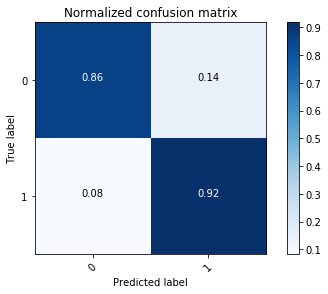

              precision    recall  f1-score   support

           0       0.94      0.86      0.89      5586
           1       0.82      0.92      0.87      3970

   micro avg       0.88      0.88      0.88      9556
   macro avg       0.88      0.89      0.88      9556
weighted avg       0.89      0.88      0.88      9556

2019-04-08 15:54:44


Iteration: 5
[ 1  8 19  0 16 12 15  5  6 10 13  2 11  7  9 18]
[3, 4, 14, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.63 0.37]
 [0.05 0.95]]


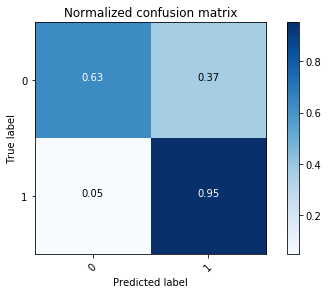

              precision    recall  f1-score   support

           0       0.96      0.63      0.76      7987
           1       0.59      0.95      0.73      4354

   micro avg       0.75      0.75      0.75     12341
   macro avg       0.77      0.79      0.74     12341
weighted avg       0.83      0.75      0.75     12341

2019-04-08 15:55:51


Iteration: 6
[18  5 11  9  7 14 17  4 10 19 12  6 15  8  3  0]
[1, 2, 13, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.95 0.05]
 [0.21 0.79]]


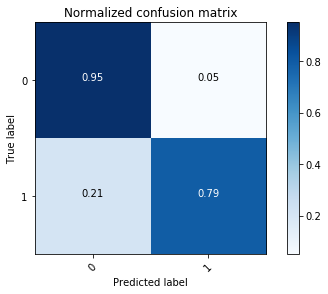

              precision    recall  f1-score   support

           0       0.89      0.95      0.92      7416
           1       0.90      0.79      0.84      4206

   micro avg       0.89      0.89      0.89     11622
   macro avg       0.90      0.87      0.88     11622
weighted avg       0.89      0.89      0.89     11622

2019-04-08 15:57:13


Iteration: 7
[ 0 13  2  1  6 11 10  3 15  7 17  4  5 18 16  8]
[9, 12, 14, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.77 0.23]
 [0.07 0.93]]


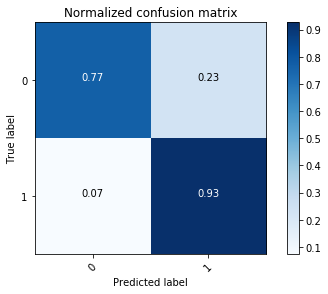

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      5569
           1       0.76      0.93      0.83      4395

   micro avg       0.84      0.84      0.84      9964
   macro avg       0.84      0.85      0.84      9964
weighted avg       0.85      0.84      0.84      9964

2019-04-08 15:58:35


Iteration: 8
[13 10 19 15  3  2  8 16  0 14  7 18  5 17  4  9]
[1, 6, 11, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.18 0.82]]


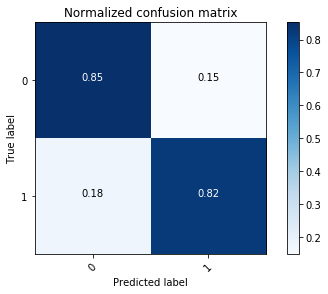

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      8078
           1       0.75      0.82      0.78      4241

   micro avg       0.84      0.84      0.84     12319
   macro avg       0.82      0.84      0.83     12319
weighted avg       0.85      0.84      0.84     12319

2019-04-08 15:59:49


Iteration: 9
[ 3  2 14 17  6 16 19  9  7  4 10  1 15 18 11  8]
[0, 5, 12, 13]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.8  0.2 ]
 [0.06 0.94]]


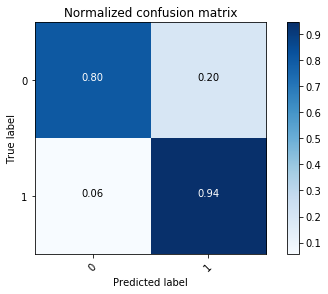

              precision    recall  f1-score   support

           0       0.97      0.80      0.88      6291
           1       0.71      0.94      0.81      3204

   micro avg       0.85      0.85      0.85      9495
   macro avg       0.84      0.87      0.84      9495
weighted avg       0.88      0.85      0.85      9495

2019-04-08 16:01:13

   sensitivity  specificity  accuracy
0     0.872064     0.552776  0.683113
1     0.869051     0.947245  0.921341
2     0.955775     0.651189  0.743148
3     0.903689     0.698210  0.786645
4     0.917632     0.857143  0.882273
5     0.952458     0.633655  0.746131
6     0.793628     0.950243  0.893564
7     0.926735     0.766924  0.837415
8     0.824098     0.852191  0.842520
9     0.944444     0.802257  0.850237
avg sensitivity: 0.8959574672335553
avg specificity: 0.7711833343849304
avg accuracy: 0.818638722794779


In [24]:
model3 = SVC(kernel='rbf', C=1,gamma=0.01,class_weight='balanced')
validateSVC(dfull, model3)

2019-04-08 16:01:13

Iteration: 0
[ 4  7  0  1 18  8 13 15 10 12  5 14 16  3  6  9]
[2, 11, 17, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.63 0.37]
 [0.17 0.83]]


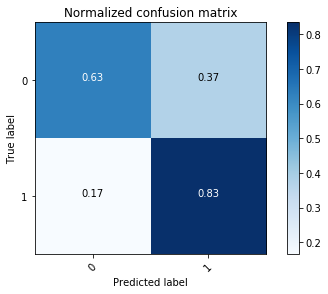

              precision    recall  f1-score   support

           0       0.85      0.63      0.72      6997
           1       0.60      0.83      0.70      4691

   micro avg       0.71      0.71      0.71     11688
   macro avg       0.72      0.73      0.71     11688
weighted avg       0.75      0.71      0.71     11688

2019-04-08 16:02:37


Iteration: 1
[11 13 18  1  5  7 15  8  2 10 14 12 16 17  9  0]
[3, 4, 6, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.07 0.93]]


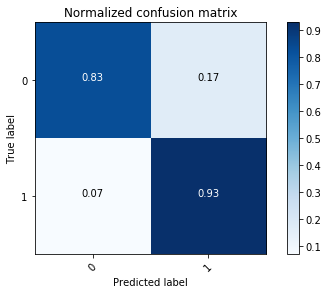

              precision    recall  f1-score   support

           0       0.94      0.83      0.88      6538
           1       0.80      0.93      0.86      4855

   micro avg       0.87      0.87      0.87     11393
   macro avg       0.87      0.88      0.87     11393
weighted avg       0.88      0.87      0.87     11393

2019-04-08 16:04:24


Iteration: 2
[ 5 11  7  0 16  2  6 15  9  3 18 14  1 19 13 17]
[4, 8, 10, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.1  0.9 ]]


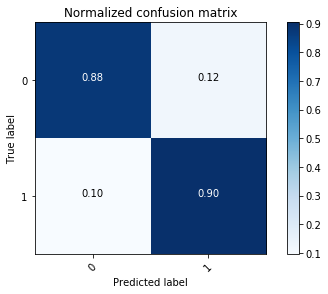

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      7171
           1       0.82      0.90      0.86      4514

   micro avg       0.89      0.89      0.89     11685
   macro avg       0.88      0.89      0.88     11685
weighted avg       0.89      0.89      0.89     11685

2019-04-08 16:06:02


Iteration: 3
[15 16 11 12  1  0  5  9 18  7 13 17  8  4  6  3]
[2, 10, 14, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.09 0.91]]


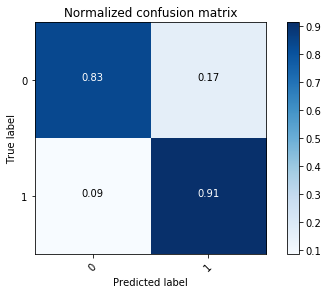

              precision    recall  f1-score   support

           0       0.93      0.83      0.88      7130
           1       0.79      0.91      0.85      4988

   micro avg       0.87      0.87      0.87     12118
   macro avg       0.86      0.87      0.87     12118
weighted avg       0.88      0.87      0.87     12118

2019-04-08 16:07:46


Iteration: 4
[ 5  3  8 13 19 14  1  4 18  9  7 16 17 15 12 10]
[0, 2, 6, 11]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.21 0.79]]


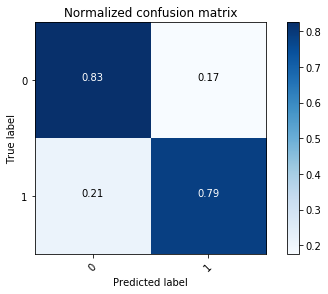

              precision    recall  f1-score   support

           0       0.89      0.83      0.86      8391
           1       0.67      0.79      0.73      3864

   micro avg       0.81      0.81      0.81     12255
   macro avg       0.78      0.81      0.79     12255
weighted avg       0.82      0.81      0.82     12255

2019-04-08 16:09:45


Iteration: 5
[11  2  4  8 12 16 19  0 15 10  6 14  7 13  9  1]
[3, 5, 17, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.7  0.3 ]
 [0.05 0.95]]


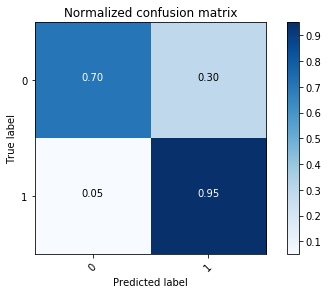

              precision    recall  f1-score   support

           0       0.97      0.70      0.82      8173
           1       0.61      0.95      0.74      3920

   micro avg       0.78      0.78      0.78     12093
   macro avg       0.79      0.83      0.78     12093
weighted avg       0.85      0.78      0.79     12093

2019-04-08 16:11:33


Iteration: 6
[16 15  8  0  6 11 18  1  5 10  4 14 17 12 19  3]
[2, 7, 9, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.93 0.07]
 [0.19 0.81]]


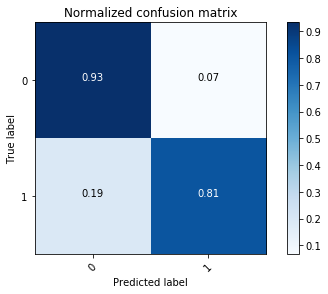

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      6676
           1       0.88      0.81      0.84      3920

   micro avg       0.89      0.89      0.89     10596
   macro avg       0.88      0.87      0.88     10596
weighted avg       0.89      0.89      0.89     10596

2019-04-08 16:13:37


Iteration: 7
[ 5 17 11  1  2 16  8 12 13 10 18 15  6 19  4 14]
[0, 3, 7, 9]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.11 0.89]]


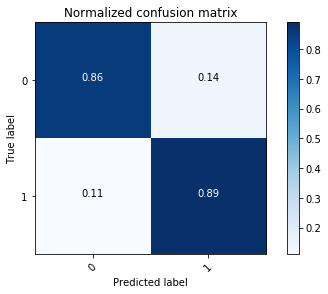

              precision    recall  f1-score   support

           0       0.94      0.86      0.89      7570
           1       0.76      0.89      0.82      3872

   micro avg       0.87      0.87      0.87     11442
   macro avg       0.85      0.87      0.86     11442
weighted avg       0.88      0.87      0.87     11442

2019-04-08 16:15:21


Iteration: 8
[11  4  3  8  7 14 19  6  0  9 12 15 10 18  2  5]
[1, 13, 16, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.74 0.26]
 [0.12 0.88]]


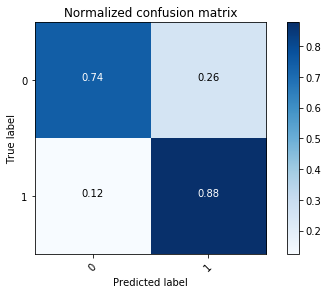

              precision    recall  f1-score   support

           0       0.92      0.74      0.82      7366
           1       0.65      0.88      0.75      4061

   micro avg       0.79      0.79      0.79     11427
   macro avg       0.79      0.81      0.79     11427
weighted avg       0.82      0.79      0.80     11427

2019-04-08 16:17:04


Iteration: 9
[ 0  4 14 15 12 19  3 16  2 11  8 13  5 17  6  7]
[1, 9, 10, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.94 0.06]
 [0.12 0.88]]


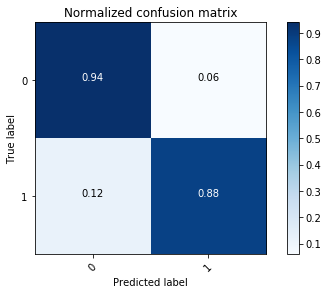

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7562
           1       0.91      0.88      0.89      4914

   micro avg       0.92      0.92      0.92     12476
   macro avg       0.91      0.91      0.91     12476
weighted avg       0.92      0.92      0.92     12476

2019-04-08 16:19:04

   sensitivity  specificity  accuracy
0     0.834151     0.626411  0.709788
1     0.928733     0.830835  0.872553
2     0.904519     0.877702  0.888062
3     0.914595     0.834362  0.867387
4     0.786232     0.825051  0.812811
5     0.950000     0.704270  0.783925
6     0.808929     0.933493  0.887410
7     0.889205     0.855350  0.866807
8     0.876878     0.744366  0.791459
9     0.879935     0.940095  0.916399
avg sensitivity: 0.8773175564300588
avg specificity: 0.8171935344853626
avg accuracy: 0.8396600954358198


In [25]:
model4 = SVC(kernel='rbf',C=1,gamma=0.1,class_weight='balanced')   #probability=True,
validateSVC(dfull, model4)

2019-04-08 16:19:04

Iteration: 0
[ 7 13 14 19  6 18 17  1 12 16  0  8 10  3  9  4]
[2, 5, 11, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.22 0.78]]


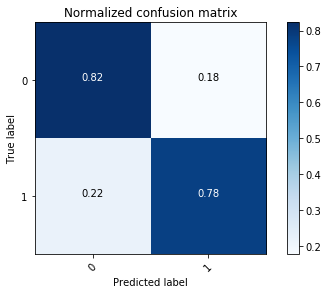

              precision    recall  f1-score   support

           0       0.89      0.82      0.85      8274
           1       0.68      0.78      0.73      4025

   micro avg       0.81      0.81      0.81     12299
   macro avg       0.78      0.80      0.79     12299
weighted avg       0.82      0.81      0.81     12299

2019-04-08 16:20:31


Iteration: 1
[ 6 18  8  3 16  9  1 12  7 17  2 19 14 13 10 15]
[0, 4, 5, 11]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.76 0.24]
 [0.16 0.84]]


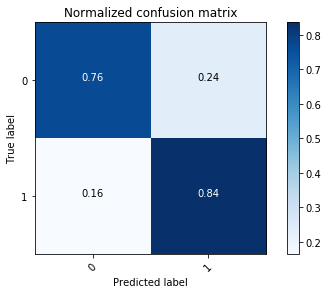

              precision    recall  f1-score   support

           0       0.89      0.76      0.82      6894
           1       0.68      0.84      0.75      4097

   micro avg       0.79      0.79      0.79     10991
   macro avg       0.78      0.80      0.78     10991
weighted avg       0.81      0.79      0.79     10991

2019-04-08 16:21:54


Iteration: 2
[ 7  5  0 12  9 18  2 11  8 17 10 16 13 14  3  6]
[1, 4, 15, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.08 0.92]]


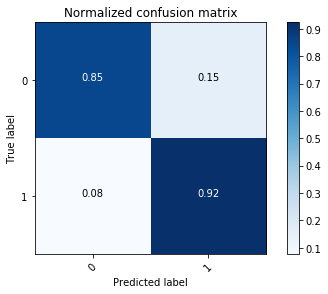

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6891
           1       0.82      0.92      0.87      5197

   micro avg       0.88      0.88      0.88     12088
   macro avg       0.88      0.88      0.88     12088
weighted avg       0.89      0.88      0.88     12088

2019-04-08 16:23:32


Iteration: 3
[10 19  7 17 16 15 11 18  8 13  1  3 12  5 14  0]
[2, 4, 6, 9]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.91 0.09]
 [0.17 0.83]]


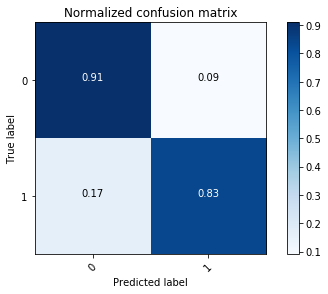

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      7123
           1       0.86      0.83      0.85      4805

   micro avg       0.88      0.88      0.88     11928
   macro avg       0.88      0.87      0.87     11928
weighted avg       0.88      0.88      0.88     11928

2019-04-08 16:25:05


Iteration: 4
[ 0 14  9 15 13  4 17  2  3 16  8 19 10  5  7 11]
[1, 6, 12, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.91 0.09]
 [0.1  0.9 ]]


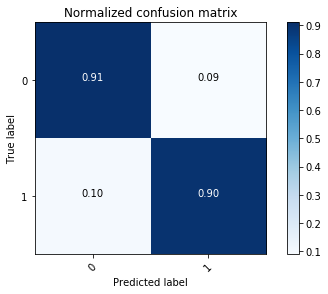

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      8355
           1       0.83      0.90      0.86      4170

   micro avg       0.91      0.91      0.91     12525
   macro avg       0.89      0.90      0.90     12525
weighted avg       0.91      0.91      0.91     12525

2019-04-08 16:26:46


Iteration: 5
[15  7 16  6 14 10  9  0 11 17 19 12  4 18  8  2]
[1, 3, 5, 13]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.06 0.94]]


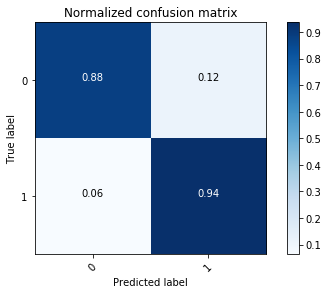

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      7139
           1       0.82      0.94      0.87      3959

   micro avg       0.90      0.90      0.90     11098
   macro avg       0.89      0.91      0.90     11098
weighted avg       0.91      0.90      0.90     11098

2019-04-08 16:28:37


Iteration: 6
[ 1  3  4 10  6 16  5  9 17 19  7  0 14 18  2 12]
[8, 11, 13, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.22 0.78]]


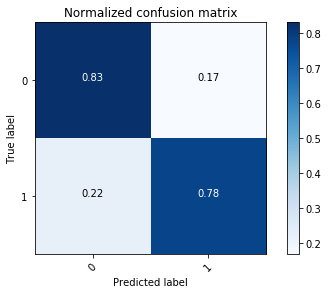

              precision    recall  f1-score   support

           0       0.90      0.83      0.86      7354
           1       0.66      0.78      0.71      3061

   micro avg       0.82      0.82      0.82     10415
   macro avg       0.78      0.80      0.79     10415
weighted avg       0.83      0.82      0.82     10415

2019-04-08 16:30:03


Iteration: 7
[12  1  5 19  2  6  9  7 10 15 17 14  3 11  8 18]
[0, 4, 13, 16]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.15 0.85]]


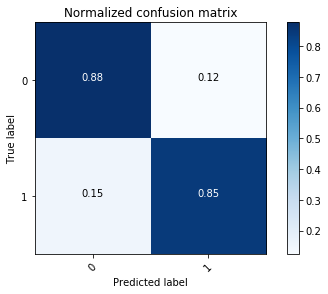

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      6218
           1       0.80      0.85      0.82      3735

   micro avg       0.86      0.86      0.86      9953
   macro avg       0.85      0.86      0.86      9953
weighted avg       0.87      0.86      0.87      9953

2019-04-08 16:31:38


Iteration: 8
[15  0  7 16  1  5 19 10  6  4 11 17  3 13 12  2]
[8, 9, 14, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.88 0.12]
 [0.12 0.88]]


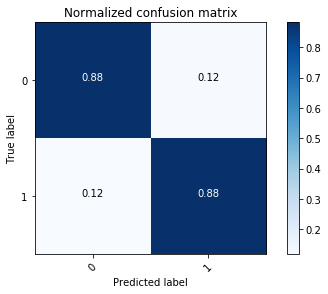

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      7418
           1       0.78      0.88      0.83      3575

   micro avg       0.88      0.88      0.88     10993
   macro avg       0.86      0.88      0.87     10993
weighted avg       0.89      0.88      0.88     10993

2019-04-08 16:33:13


Iteration: 9
[16 14  4 13  8 19  9  3  0  6  5  2 12  1 15 17]
[7, 10, 11, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.23 0.77]]


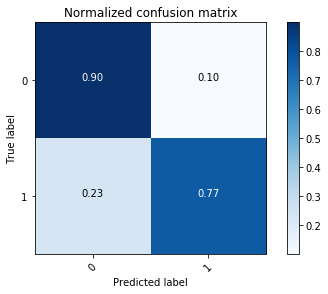

              precision    recall  f1-score   support

           0       0.88      0.90      0.89      8229
           1       0.80      0.77      0.78      4215

   micro avg       0.85      0.85      0.85     12444
   macro avg       0.84      0.83      0.84     12444
weighted avg       0.85      0.85      0.85     12444

2019-04-08 16:34:36

   sensitivity  specificity  accuracy
0     0.781118     0.822818  0.809171
1     0.835978     0.763708  0.790647
2     0.923802     0.845741  0.879302
3     0.834339     0.909589  0.879276
4     0.897602     0.910353  0.906108
5     0.935842     0.883177  0.901964
6     0.777524     0.830976  0.815266
7     0.845248     0.876648  0.864865
8     0.881678     0.877325  0.878741
9     0.767023     0.899259  0.854468
avg sensitivity: 0.8480153486012088
avg specificity: 0.861959443786416
avg accuracy: 0.857980825463555


In [26]:
model5 = SVC(kernel='rbf',C=0.1,gamma=0.1,class_weight='balanced')  #probability=True,
validateSVC(dfull, model5)

2019-04-08 16:34:36

Iteration: 0
[ 3  0 13 10  8  7 11 17 16  9 19 14 18  2 15  4]
[1, 5, 6, 12]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.07 0.93]]


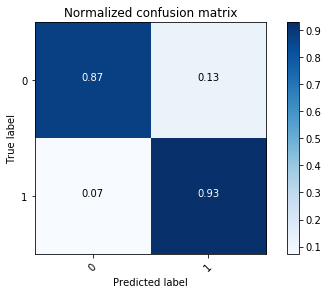

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7933
           1       0.80      0.93      0.86      4303

   micro avg       0.89      0.89      0.89     12236
   macro avg       0.88      0.90      0.88     12236
weighted avg       0.90      0.89      0.89     12236

2019-04-08 16:36:18


Iteration: 1
[13  5  9  2 11 18  0 19  4 10 16 17  1  3  7 14]
[6, 8, 12, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.09 0.91]]


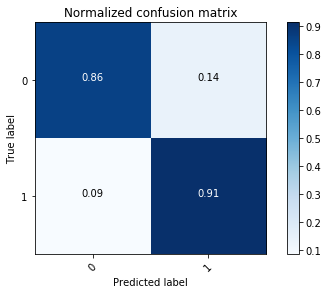

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      8508
           1       0.72      0.91      0.81      3467

   micro avg       0.87      0.87      0.87     11975
   macro avg       0.84      0.89      0.86     11975
weighted avg       0.89      0.87      0.88     11975

2019-04-08 16:38:00


Iteration: 2
[15 11 10 18  2  9 16  5  8 12  1 19  6 14 17  4]
[0, 3, 7, 13]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.08 0.92]]


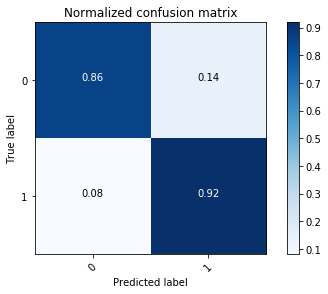

              precision    recall  f1-score   support

           0       0.96      0.86      0.90      7433
           1       0.74      0.92      0.82      3253

   micro avg       0.87      0.87      0.87     10686
   macro avg       0.85      0.89      0.86     10686
weighted avg       0.89      0.87      0.88     10686

2019-04-08 16:39:53


Iteration: 3
[14 12  4 16 10  8 15 11 13  3  1 19 17  5 18  2]
[0, 6, 7, 9]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.12 0.88]]


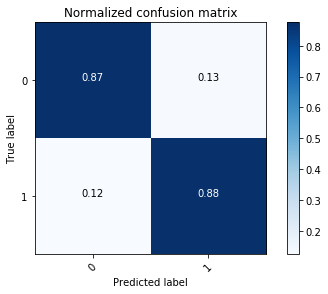

              precision    recall  f1-score   support

           0       0.93      0.87      0.90      7691
           1       0.77      0.88      0.82      3851

   micro avg       0.87      0.87      0.87     11542
   macro avg       0.85      0.87      0.86     11542
weighted avg       0.88      0.87      0.87     11542

2019-04-08 16:41:46


Iteration: 4
[ 1 19 13 15  6 10 17 16 11  4  3 18  8  0 14 12]
[2, 5, 7, 9]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.91 0.09]
 [0.17 0.83]]


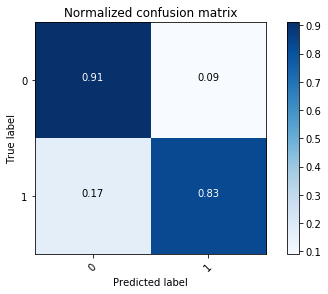

              precision    recall  f1-score   support

           0       0.90      0.91      0.91      7365
           1       0.85      0.83      0.84      4357

   micro avg       0.88      0.88      0.88     11722
   macro avg       0.87      0.87      0.87     11722
weighted avg       0.88      0.88      0.88     11722

2019-04-08 16:43:41


Iteration: 5
[10 13 14 11  4 12  2 18  0  6  7  1 16  8 19  5]
[3, 9, 15, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.67 0.33]
 [0.08 0.92]]


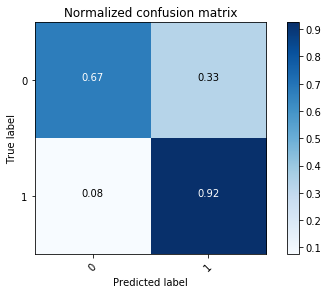

              precision    recall  f1-score   support

           0       0.95      0.67      0.79      8032
           1       0.59      0.92      0.72      4124

   micro avg       0.76      0.76      0.76     12156
   macro avg       0.77      0.80      0.75     12156
weighted avg       0.83      0.76      0.76     12156

2019-04-08 16:45:27


Iteration: 6
[ 4  6  0  3 19  8 12  1 13 18  9  2 16 14 17  7]
[5, 10, 11, 15]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.16 0.84]]


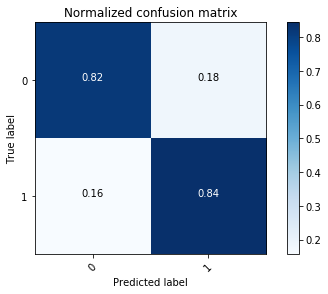

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      8019
           1       0.71      0.84      0.77      4260

   micro avg       0.83      0.83      0.83     12279
   macro avg       0.81      0.83      0.82     12279
weighted avg       0.84      0.83      0.83     12279

2019-04-08 16:47:19


Iteration: 7
[14  4 17 18  9 10 12  7 16  8 15 11  1  6 19 13]
[0, 2, 3, 5]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.83 0.17]
 [0.09 0.91]]


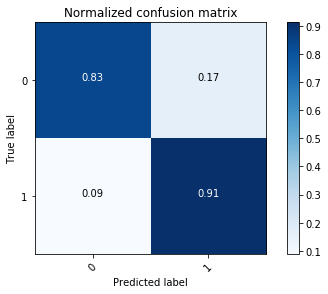

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      8125
           1       0.73      0.91      0.81      3947

   micro avg       0.86      0.86      0.86     12072
   macro avg       0.84      0.87      0.85     12072
weighted avg       0.88      0.86      0.86     12072

2019-04-08 16:49:01


Iteration: 8
[16 15 19 12  2  0  5  9  7 17 10  6  4 11  3  1]
[8, 13, 14, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.08 0.92]]


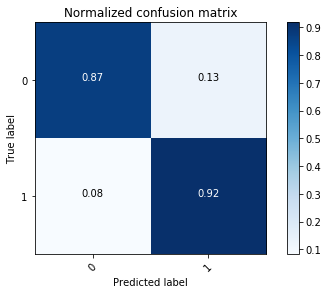

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7281
           1       0.74      0.92      0.82      2956

   micro avg       0.88      0.88      0.88     10237
   macro avg       0.85      0.89      0.87     10237
weighted avg       0.90      0.88      0.89     10237

2019-04-08 16:51:01


Iteration: 9
[10 16  7  3 13  2  8  4 11  5  1 19  9 15 17 14]
[0, 6, 12, 18]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.08 0.92]]


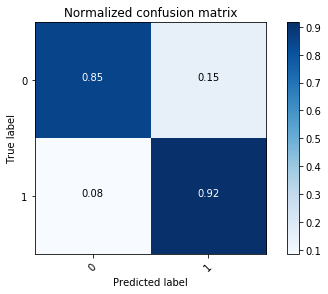

              precision    recall  f1-score   support

           0       0.96      0.85      0.90      8028
           1       0.73      0.92      0.81      3487

   micro avg       0.87      0.87      0.87     11515
   macro avg       0.84      0.88      0.86     11515
weighted avg       0.89      0.87      0.87     11515

2019-04-08 16:52:48

   sensitivity  specificity  accuracy
0     0.928190     0.871423  0.891386
1     0.914335     0.856488  0.873236
2     0.918537     0.855913  0.874977
3     0.876136     0.870628  0.872466
4     0.830158     0.910387  0.880566
5     0.924830     0.672186  0.757897
6     0.843427     0.818182  0.826940
7     0.911832     0.834954  0.860089
8     0.917794     0.869661  0.883560
9     0.915974     0.849527  0.869648
avg sensitivity: 0.8981213160769057
avg specificity: 0.8409348310566672
avg accuracy: 0.8590765844237171


In [27]:
model6 = SVC(kernel='rbf',C=0.5, gamma=0.1,class_weight='balanced')         #probability=True,
validateSVC(dfull, model6)

2019-04-08 16:52:48

Iteration: 0
[15  5  3  6 11 12  9  1  7 14 18 10  4  2 16 17]
[0, 8, 13, 19]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.82 0.18]
 [0.06 0.94]]


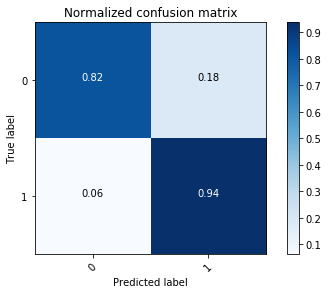

              precision    recall  f1-score   support

           0       0.96      0.82      0.88      5682
           1       0.76      0.94      0.84      3449

   micro avg       0.86      0.86      0.86      9131
   macro avg       0.86      0.88      0.86      9131
weighted avg       0.88      0.86      0.86      9131

2019-04-08 16:55:10


Iteration: 1
[ 5  4 14  1 17 16 10  0  3 18  7 13  8  6  2 11]
[9, 12, 15, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.78 0.22]
 [0.1  0.9 ]]


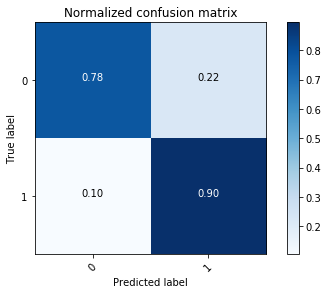

              precision    recall  f1-score   support

           0       0.91      0.78      0.84      5919
           1       0.75      0.90      0.82      4429

   micro avg       0.83      0.83      0.83     10348
   macro avg       0.83      0.84      0.83     10348
weighted avg       0.84      0.83      0.83     10348

2019-04-08 16:57:21


Iteration: 2
[16  2  7  6 14 17 11 12 13  9  0 15  5  4 10  1]
[3, 8, 18, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.09 0.91]]


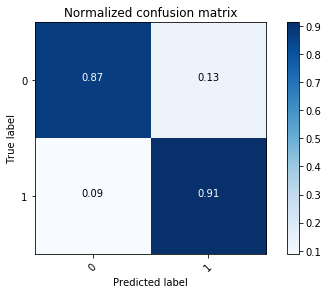

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      6974
           1       0.80      0.91      0.85      4004

   micro avg       0.88      0.88      0.88     10978
   macro avg       0.87      0.89      0.88     10978
weighted avg       0.89      0.88      0.88     10978

2019-04-08 16:59:30


Iteration: 3
[17 12  2 15 13  4  7 14 10  8 19  5  6  9  3  0]
[1, 11, 16, 18]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.9  0.1 ]
 [0.29 0.71]]


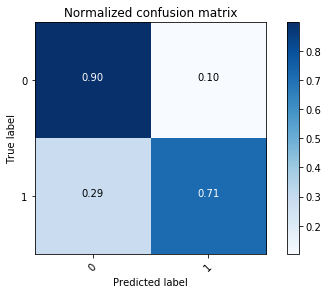

              precision    recall  f1-score   support

           0       0.86      0.90      0.88      8048
           1       0.79      0.71      0.75      4214

   micro avg       0.83      0.83      0.83     12262
   macro avg       0.82      0.81      0.81     12262
weighted avg       0.83      0.83      0.83     12262

2019-04-08 17:01:00


Iteration: 4
[10  9 12  3 15  1  7 14 17  0  8 11  2  5 16  6]
[4, 13, 18, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.87 0.13]
 [0.1  0.9 ]]


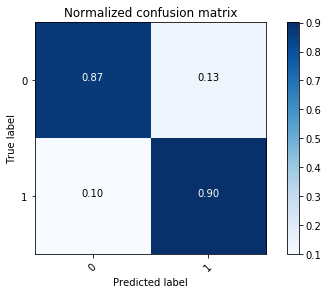

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5140
           1       0.85      0.90      0.88      4306

   micro avg       0.88      0.88      0.88      9446
   macro avg       0.88      0.88      0.88      9446
weighted avg       0.89      0.88      0.88      9446

2019-04-08 17:03:25


Iteration: 5
[17  7 19 13  2 18  5  1  0  4  8  3  6 14 10 12]
[9, 11, 15, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.84 0.16]
 [0.31 0.69]]


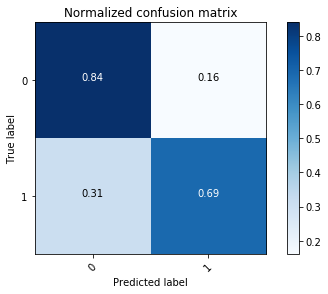

              precision    recall  f1-score   support

           0       0.83      0.84      0.84      7256
           1       0.70      0.69      0.70      3986

   micro avg       0.79      0.79      0.79     11242
   macro avg       0.77      0.76      0.77     11242
weighted avg       0.79      0.79      0.79     11242

2019-04-08 17:05:04


Iteration: 6
[ 2 14  1 11 13  5  8 18 12  3  9 19 17 10  6  4]
[0, 7, 15, 16]
         0         1         2    3         4         5         6         7   \
0  0.151007  0.053691  0.030201  0.0  0.060403  0.127517  0.036913  0.030201   

         8         9         10        11        12        13        14  \
0  0.020134  0.063758  0.144295  0.033557  0.003356  0.010067  0.050336   

         15  
0  0.184564  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.19 0.81]]


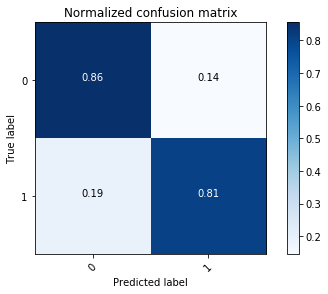

              precision    recall  f1-score   support

           0       0.91      0.86      0.88      8608
           1       0.70      0.81      0.75      3592

   micro avg       0.84      0.84      0.84     12200
   macro avg       0.81      0.83      0.82     12200
weighted avg       0.85      0.84      0.84     12200

2019-04-08 17:06:58


Iteration: 7
[10 14  8 19  2 11  5 16 18  7  6  1  0  9 13  3]
[4, 12, 15, 17]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.62 0.38]
 [0.08 0.92]]


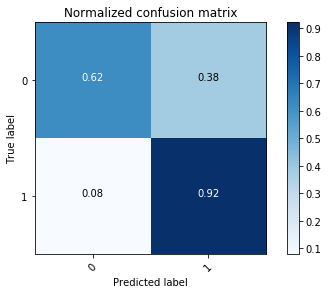

              precision    recall  f1-score   support

           0       0.93      0.62      0.75      7816
           1       0.57      0.92      0.71      4316

   micro avg       0.73      0.73      0.73     12132
   macro avg       0.75      0.77      0.73     12132
weighted avg       0.81      0.73      0.73     12132

2019-04-08 17:08:32


Iteration: 8
[15 17 14  4 12  1  9 18  0 11  6  3  2 16  7  8]
[5, 10, 13, 19]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.86 0.14]
 [0.07 0.93]]


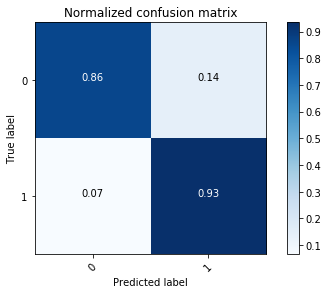

              precision    recall  f1-score   support

           0       0.94      0.86      0.90      5334
           1       0.85      0.93      0.89      4462

   micro avg       0.89      0.89      0.89      9796
   macro avg       0.89      0.90      0.89      9796
weighted avg       0.90      0.89      0.89      9796

2019-04-08 17:10:52


Iteration: 9
[19  8 13  2  1 12 17  9  6  3 11  0 15 18  7 10]
[4, 5, 14, 16]
        0         1         2         3        4        5         6   \
0  0.09396  0.043624  0.026846  0.003356  0.04698  0.11745  0.107383   

         7         8         9         10       11        12        13  \
0  0.026846  0.026846  0.104027  0.134228  0.07047  0.003356  0.033557   

         14       15  
0  0.067114  0.09396  



C:\Users\DAR9KOR\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Normalized confusion matrix
[[0.85 0.15]
 [0.15 0.85]]


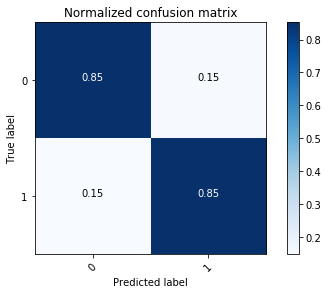

              precision    recall  f1-score   support

           0       0.90      0.85      0.88      7066
           1       0.77      0.85      0.81      4278

   micro avg       0.85      0.85      0.85     11344
   macro avg       0.84      0.85      0.84     11344
weighted avg       0.86      0.85      0.85     11344

2019-04-08 17:13:03

   sensitivity  specificity  accuracy
0     0.937663     0.815734  0.861790
1     0.895010     0.776651  0.827310
2     0.912088     0.866074  0.882857
3     0.714998     0.897614  0.834856
4     0.900836     0.868872  0.883443
5     0.689413     0.839443  0.786248
6     0.805958     0.855483  0.840902
7     0.921687     0.620906  0.727910
8     0.934110     0.858830  0.893120
9     0.852034     0.848854  0.850053
avg sensitivity: 0.8563796133917394
avg specificity: 0.824846139309748
avg accuracy: 0.8388485964728533


In [28]:
model7 = SVC(kernel='linear',class_weight='balanced')                 #probability=True,
validateSVC(dfull, model7)